In [20]:
import numpy as np
import configparser
import os
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

import sys
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))


## Env-related functions

In [18]:
from configparser import SectionProxy

class EvalSectionProxy(SectionProxy):
    def __init__(self, sectionproxy: SectionProxy):
        super().__init__(sectionproxy._parser, sectionproxy._name)
    def eval(self, *args, globals=None, locals=None, **kwargs):
        return eval(self.get(*args, **kwargs), globals, locals)

class EvalConfigParser(configparser.ConfigParser):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def eval(self, *args, globals=None, locals=None, **kwargs):
        return eval(self.get(*args, **kwargs), globals, locals)
    def __getitem__(self, key: str) -> EvalSectionProxy:
        return EvalSectionProxy(super().__getitem__(key))


def validate_config_eval(config: configparser.ConfigParser, **kwargs):
    if bool(config.get('ExternalSources', 'variables')) and not any(['globals' in kwargs, 'locals' in kwargs]):
        raise ValueError(
            f'Parser requires external sources that has not been provided: '
            f'{", ".join([variable  + " " + str(value) for variable, value in config.eval("ExternalSources", "variables").items()])}'
        )

In [19]:
import configparser
from dataclasses import dataclass
import pandas as pd
import torch

@dataclass
class Coordinates2D:
    x: np.ndarray | pd.DataFrame | torch.Tensor
    y: np.ndarray | pd.DataFrame | torch.Tensor

    def __post_init__(self):
        if type(self.x) != type(self.y):
            raise ValueError(f'x and y must have the same type, got {type(self.x)} and {type(self.y)} instead')
        if hasattr(self.x, 'shape') and (self.x.shape != self.y.shape):
            raise ValueError(f'x and y must have the same shape, got {self.x.shape} and {self.y.shape} instead')

@dataclass
class GeometryParams:
    max_xy: int
    min_xy: int
    min_train: Coordinates2D
    max_train: Coordinates2D
    max_n_obj_points: int
    n_objects: int
    n_polygons: int
    n_vertices: list[int]
    objects: Coordinates2D

def get_objects(
    config: configparser.ConfigParser,
    n_objects: int,
    max_n_obj_points: int,
    *args, **kwargs
) -> tuple[list[int], list[list[float]], list[list[float]]]:
    object_x = [[0.0] * max_n_obj_points for _ in range(n_objects)]
    object_y = [[0.0] * max_n_obj_points for _ in range(n_objects)]
    n_vertices = [0] * n_objects

    for i in range(n_objects):
        section_name = f'Object{i + 1}'
        n_vertices_i = config.eval(section_name, 'n_vertices')
        n_vertices[i] = n_vertices_i

        object_x_i = config.eval(section_name, 'object_x', *args, **kwargs)
        object_y_i = config.eval(section_name, 'object_y', *args, **kwargs)

        object_x[i][:n_vertices_i] = object_x_i
        object_y[i][:n_vertices_i] = object_y_i

    return n_vertices, object_x, object_y

def get_coords(config: configparser.ConfigParser, *args, **kwargs) -> tuple[int, int, int, int, int, int]:
    max_xy = config.eval('GridBoundaries', 'max_xy', *args, **kwargs)
    min_xy = config.eval('GridBoundaries', 'min_xy', *args, **kwargs)

    min_train_x = config.eval('TrainingRectangle', 'min_train_x', *args, **kwargs)
    min_train_y = config.eval('TrainingRectangle', 'min_train_y', *args, **kwargs)
    max_train_x = config.eval('TrainingRectangle', 'max_train_x', *args, **kwargs)
    max_train_y = config.eval('TrainingRectangle', 'max_train_y', *args, **kwargs)

    return max_xy, min_xy, min_train_x, min_train_y, max_train_x, max_train_y

def get_building(config: configparser.ConfigParser, *args, **kwargs) -> tuple[int, int]:
    n_objects = config.eval('BuildingBoundaries', 'n_objects', *args, **kwargs)
    n_polygons = config.eval('BuildingBoundaries', 'n_polygons', *args, **kwargs)
    max_n_obj_points = config.eval('BuildingBoundaries', 'max_n_obj_points', *args, **kwargs)

    return n_objects, n_polygons, max_n_obj_points

def get_geometry_params(config: str | configparser.ConfigParser, *args, **kwargs) -> GeometryParams:
    if isinstance(config, str):
        cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
        cfg.read(config)
        config = cfg

    validate_config_eval(config, **kwargs)

    max_xy, min_xy, min_train_x, min_train_y, max_train_x, max_train_y = get_coords(config, *args, **kwargs)
    n_objects, n_polygons, max_n_obj_points = get_building(config, *args, **kwargs)

    n_vertices, object_x, object_y = get_objects(config, n_objects, max_n_obj_points, *args, **kwargs)

    return GeometryParams(
        max_xy, min_xy,
        Coordinates2D(min_train_x, min_train_y),
        Coordinates2D(max_train_x, max_train_y),
        max_n_obj_points,
        n_objects,
        n_polygons,
        np.array(n_vertices),
        Coordinates2D(
            np.array(object_x),
            np.array(object_y)
        )
    )


## Processing

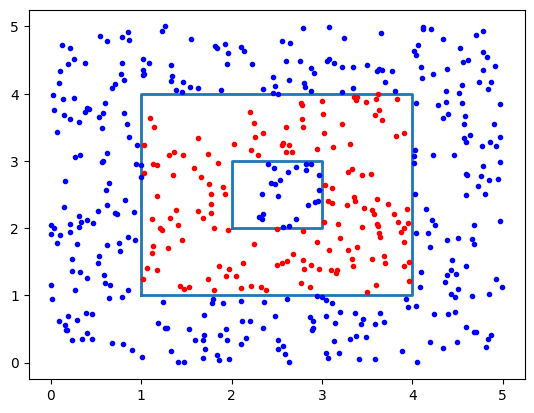

In [4]:
from shapely.geometry import Point, Polygon

def inpolygon(point_x, point_y, polygon_x, polygon_y):
    # Create a Polygon object from the polygon vertices
    polygon = Polygon(list(zip(polygon_x, polygon_y)))

    # If single point coordinates are provided, convert them into a list
    if isinstance(point_x, (int, float)):
        point_x = [point_x]
        point_y = [point_y]

    # Create Point objects for the input points
    points = [Point(x, y) for x, y in zip(point_x, point_y)]

    # Check if each point is inside or on the edge of the polygon
    # is_inside = [point.within(polygon) for point in points]

    # is_inside = [polygon.contains(point) for point in points]
    is_inside = [polygon.covers(point) for point in points]

    return np.array(is_inside)


xv = np.array([1, 4, 4, 1, 1, 2, 2, 3, 3, 2])
yv = np.array([1, 1, 4, 4, 1, 2, 3, 3, 2, 2])

np.random.seed()  # Use a random seed for default behavior
xq = np.random.rand(500, 1) * 5
yq = np.random.rand(500, 1) * 5

in_ = inpolygon(xq,yq,xv,yv)

xv = np.array([1, 4, 4, 1, 1, np.nan, 2, 2, 3, 3, 2])
yv = np.array([1, 1, 4, 4, 1, np.nan, 2, 3, 3, 2, 2])
plt.plot(xv, yv, linewidth=2)
plt.plot(xq[in_], yq[in_], 'r.')
plt.plot(xq[np.logical_not(in_)], yq[ np.logical_not(in_)], 'b.')

In [5]:
def get_two_room(cfg_path: str = '../cfg/envs/two_room.ini') -> GeometryParams:
    config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
    config.read(cfg_path)
    geometry = get_geometry_params(config)

    # Scale the objects to full width after coords were between -10 and 10
    scale = config.eval('BuildingBoundaries', 'scale')
    # geometry.objects.x = [[scale * x for x in row] for row in geometry.objects.x]
    # geometry.objects.y = [[scale * y for y in row] for row in geometry.objects.y]
    geometry.objects.x *= scale
    geometry.objects.y *= scale

    return geometry


def get_preplay_env(preplay_env_closed_cfg_path: str) -> GeometryParams:
    config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
    config.read(preplay_env_closed_cfg_path)
    datapath = config.eval('ExternalSources', 'paths')
    red_grid = np.load(datapath)[2:-2, 2:-2]
    y_range = config.eval('RoomDimensions', 'y_range', locals={'red_grid': red_grid})
    x_barrier_top_min = (red_grid[y_range // 2, :] == 1).argmax() + 1
    y_barrier_top = np.where(red_grid[:, -1] == 1)[0][-1] + 1
    x_barrier_bot_min = x_barrier_top_min
    y_barrier_bot = np.where(red_grid[:, -1] == 1)[0][0] + 1

    return get_geometry_params(
        config,
        locals={
            'red_grid': red_grid,
            'x_barrier_bot_min': x_barrier_bot_min,
            'x_barrier_top_min': x_barrier_top_min,
            'y_barrier_bot': y_barrier_bot,
            'y_barrier_top': y_barrier_top,
        }
    )


def get_complex_grid(geometry: GeometryParams, res: float) -> np.ndarray: #!
    min_xy, max_xy = geometry.min_xy, geometry.max_xy
    grid_x = np.arange(min_xy, max_xy + res, res)  # Create a Cartesian grid of possible locations over the environment along the x-axis
    grid_y = np.arange(min_xy, max_xy + res, res)  # Create a Cartesian grid of possible locations over the environment along the y-axis

    # Create 2D grids of x and y values
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)

    # Convert Cartesian coordinates to complex numbers
    complex_grid = grid_x + 1j * grid_y

    # Reshape the complex grid into a 1D vector of grid points (x and y values as complex numbers)
    complex_grid = complex_grid.reshape(-1, 1)

    return complex_grid, grid_x, grid_y


def get_geometry_name(config: str | configparser.ConfigParser) -> str:

    if isinstance(config, str):
        cfg = configparser.ConfigParser(allow_no_value=True)
        cfg.read(config)
        config = cfg

    environment_section = config['Environment']
    two_room = environment_section.getboolean('two_room')
    square_room = environment_section.getboolean('square_room')
    inserted_barrier = environment_section.getboolean('inserted_barrier')
    preplay_env_closed = environment_section.getboolean('preplay_env_closed')
    preplay_env_open = environment_section.getboolean('preplay_env_open')

    if two_room:
        return 'two_room'
    elif square_room:
        return 'squared_room'
    elif inserted_barrier:
        return 'inserted_barrier'
    elif preplay_env_open:
        return 'preplay_env_open'
    elif preplay_env_closed:
        return 'preplay_env_closed'


def get_geometry_by_name(cfg_path: str, geometry_name: str) -> tuple[GeometryParams, int]:

    match geometry_name:
        case 'two_room':
            geometry = get_two_room(cfg_path)
            n_textures = geometry.n_polygons + 2
        case 'squared_room':
            geometry = get_geometry_params(cfg_path)
            n_textures = geometry.n_polygons
        case 'inserted_barrier':
            geometry = get_geometry_params(cfg_path)
            n_textures = geometry.n_polygons + 1
        case 'preplay_env_closed' | 'preplay_env_open':
            geometry = get_preplay_env(cfg_path)
            n_textures = geometry.n_polygons
        case _:
            raise ValueError(f"Unsupported geometry name: {geometry_name}")

    return geometry, n_textures

class AbstractBuildingGeometryProcessor(ABC):

    @abstractmethod
    def get_line_identity(self, poly: int, xf: float, xi: float) -> int:
        pass

    def __call__(self, geometry: GeometryParams, complex_grid: np.ndarray):
        foreground_pts = []  # Will be the possible locations from above that are inside buildings
        line_tex = []  # Identity of each line
        dir_ = []  # Direction of each line
        r0 = []  # Starting point of each line
        for poly in range(1, geometry.n_polygons + 1):
            # Create complex vertices for the current polygon
            vertices = np.array(geometry.objects.x[poly - 1, :] + 1j * geometry.objects.y[poly - 1, :])
            vertices = vertices[:geometry.n_vertices[poly - 1]]

            # Find locations inside this building
            in_poly_pts = np.where(inpolygon(complex_grid.real, complex_grid.imag, vertices.real, -vertices.imag))

            # Locations inside this building, foreground in the sense of looking at the map from above
            # The ground is background, buildings are foreground
            foreground_pts.extend(in_poly_pts[0])

            # Loop over "lines" of the building (same as # of vertices)
            for polyline in range(geometry.n_vertices[poly - 1] - 1):
                xi, xf = geometry.objects.x.T[polyline:polyline + 2, poly - 1]
                yi, yf = geometry.objects.y.T[polyline:polyline + 2, poly - 1]
                line_tex.append(self.get_line_identity(poly, xf, xi))

                dir_.append([xf - xi, yf - yi, 0])  # Line vectors, from one vertex of a building to the next
                r0.append([xi, yi, 0])  # Line start

        return np.array(foreground_pts), np.array(line_tex), np.array(dir_), np.array(r0)


class StandartBuildingGeometryProcessor(AbstractBuildingGeometryProcessor):
    def __init__(self, geometry_name: str):
        if geometry_name not in (
            'two_room',
            'squared_room',
            'inserted_barrier',
            'preplay_env_open',
            'preplay_env_closed'
        ):
            raise NotImplementedError(f'Invalid geometry name: {geometry_name}')

        self.geometry_name = geometry_name

    def get_line_identity(self, poly: int, xf: float, xi: float) -> int:
        match self.geometry_name:
            case 'two_room':
                if poly >= 3 or (poly == 2 and xf > 0 and xi > 0):
                    return poly + 1
                else:
                    return poly
            case 'squared_room' | 'preplay_env_open' | 'preplay_env_closed':
                return poly
            case 'inserted_barrier':
                if poly >= 5 or (poly == 5 and (xf == 14 and xi == 8 or xf == 8 and xi == 14)):
                    return poly + 1
                else:
                    return poly


@dataclass
class AbstractSpace(ABC):
    coords: Coordinates2D


@dataclass
class TrainingSpace(AbstractSpace): #!
    coords: Coordinates2D
    identities: np.ndarray
    directions: np.ndarray
    starting_points: np.ndarray
    resolution: float

    def __post_init__(self):
        if self.directions.shape != self.starting_points.shape:
            raise ValueError(
                'directions and starting_points must have the same shape, '
                f'got {self.directions.shape} and {self.starting_points.shape} instead'
            )
        if len(self.identities) != len(self.directions):
            raise ValueError(
                'identities and directions must have the same length, '
                f'got {len(self.identities)} and {len(self.directions)} instead'
            )
    def plot(self, ax: plt.Axes = None, *args, **kwargs) -> plt.Figure | None:
        if not len(args) and not len(kwargs):
            args = 's',
            kwargs = dict(color='tab:gray')
        if ax is not None:
            ax.plot(self.coords.x, self.coords.y, *args, **kwargs)
        else:
            fig, ax = plt.subplots()
            ax.plot(self.coords.x, self.coords.y, *args, **kwargs)
            return fig


def process_training_space(
    geometry: GeometryParams,
    res: float,
    building_geometry_processor: AbstractBuildingGeometryProcessor,
    *args, **kwargs
) -> TrainingSpace:
    # Get the complex grid
    complex_grid, grid_x, grid_y = get_complex_grid(geometry, res)

    # Process building geometry
    building_geometry_processor = building_geometry_processor(*args, **kwargs)
    foreground_pts, line_tex, dir_, r0 = building_geometry_processor(geometry, complex_grid)

    # Create background_x and background_y based on grid_x and grid_y
    background_x = grid_x.copy()
    shape = background_x.shape
    background_x = background_x.T.reshape(-1)
    background_y = grid_y.copy()
    background_y = background_y.T.reshape(-1)

    # Convert the elements which lie within the buildings into non-numbers (NaN)
    background_x[foreground_pts] = np.nan
    background_y[foreground_pts] = np.nan

    # Reshape background_x and background_y
    background_x = background_x.reshape(shape[::-1]).T
    background_y = background_y.reshape(shape[::-1]).T

    # Remove the non-numbers (NaN) from the arrays - forms a column vector
    background_x = background_x.T[np.isfinite(background_x).T]
    background_y = background_y.T[np.isfinite(background_y).T]

    # Find the indices of locations outside of objects, but inside training rect.
    train_ind = np.where(
        (background_x > geometry.min_train.x) &
        (background_x < geometry.max_train.x) &
        (background_y > geometry.min_train.y) &
        (background_y < geometry.max_train.y)
    )[0]


    # Extract the coordinates within the specified range
    train_x = background_x[train_ind]
    train_y = background_y[train_ind]

    return TrainingSpace(Coordinates2D(train_x, train_y), line_tex, dir_, r0, res)


@dataclass
class Boundary:
    coords: Coordinates2D
    textures: np.ndarray

    def __post_init__(self):
        if self.coords.x.shape != self.coords.y.shape:
            raise ValueError(f'x and y must have the same shape, got {self.coords.x.shape} and {self.coords.y.shape} instead')
        if len(self.coords.x) != len(self.textures):
            raise ValueError(f'points and textures must have the same length, got {len(self.coords.x)} and {len(self.textures)} instead')


def process_boundary(training_space: TrainingSpace) -> Boundary:
    total_lines = len(training_space.identities)

    boundary_len = np.linalg.norm(training_space.directions, axis=1)
    Dir_unit = training_space.directions / boundary_len[:, np.newaxis]
    boundary_len[np.where(np.isclose(boundary_len % training_space.resolution, 0))[0]] += training_space.resolution

    boundary_points_x = []
    boundary_points_y = []
    boundary_textures = []

    for boundary in range(total_lines):
        x = training_space.starting_points[boundary, 0] + np.arange(0, boundary_len[boundary], training_space.resolution) * Dir_unit[boundary, 0]
        y = training_space.starting_points[boundary, 1] + np.arange(0, boundary_len[boundary], training_space.resolution) * Dir_unit[boundary, 1]

        boundary_points_x.extend(x.tolist())
        boundary_points_y.extend(y.tolist())
        boundary_textures.extend(np.full(len(x), training_space.identities[boundary]))

    boundary_points_x = np.array(boundary_points_x)
    boundary_points_y = np.array(boundary_points_y)
    boundary_textures = np.array(boundary_textures)

    return Boundary(Coordinates2D(boundary_points_x, boundary_points_y), boundary_textures)


def compute_intersection(point1: np.ndarray, point2: np.ndarray, direction1: np.ndarray, direction2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # Calculate how far along each line two lines intersect.

    denominator_2 = np.cross(direction1, direction2).astype(float)  # Cross product of direction1 and direction2
    denominator_2[denominator_2 == 0] = np.nan

    denominator_1 = -denominator_2

    alpha2 = np.cross(point2 - point1, direction1) / denominator_2
    alpha1 = np.cross(point1 - point2, direction2) / denominator_1

    return alpha1[:, 2], alpha2[:, 2]


@dataclass
class VisiblePlane(Boundary):
    training_locations: np.ndarray
    def __post_init__(self):
        super().__post_init__()
        if len(self.coords.x) != len(self.training_locations):
            raise ValueError(f'points and training_locations must have the same length, got {len(self.coords.x)} and {len(self.training_locations)} instead')


def process_visible_plane(boundary: Boundary, training_space: TrainingSpace) -> VisiblePlane:

    n_boundary_points = boundary.coords.x.shape[0]
    n_training_points = training_space.coords.x.shape[0]

    visible_plane = np.full((2, n_boundary_points, n_training_points), np.nan)
    texture = np.full((n_training_points, n_boundary_points), np.nan)

    training_locations = np.zeros((n_training_points, 2))
    occluded_points = np.zeros(n_boundary_points, dtype=bool)

    for location in range(n_training_points):
        pos = Coordinates2D(training_space.coords.x[location], training_space.coords.y[location])
        training_locations[location] = [pos.x, pos.y]

        local_r0 = training_space.starting_points - np.array([pos.x, pos.y, 0])
        Loc_bndry_pts = np.column_stack((boundary.coords.x - pos.x, boundary.coords.y - pos.y, np.zeros(n_boundary_points)))

        occluded_points.fill(False)

        for occ_bndry in range(len(training_space.identities)):
            alpha_pt, alpha_occ = compute_intersection(
                np.zeros((n_boundary_points, 3)),
                np.expand_dims(local_r0[occ_bndry], 0),
                Loc_bndry_pts,
                np.expand_dims(training_space.directions[occ_bndry], 0)
            )

            occluded_points |= (alpha_pt < 1 - 1e-5) & (alpha_pt > 0) & (alpha_occ <= 1) & (alpha_occ >= 0)

        unocc_ind = np.where(~occluded_points)[0]
        num_vis_pts = unocc_ind.size

        visible_plane[:, :num_vis_pts, location] = Loc_bndry_pts[unocc_ind, :2].T + np.array([pos.x, pos.y])[:, np.newaxis]
        texture[location, :num_vis_pts] = boundary.textures[unocc_ind].T

    visible_plane = Coordinates2D(visible_plane[0].T, visible_plane[1].T)

    return VisiblePlane(visible_plane, texture, training_locations)


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from typing import Callable, Any, Optional
from bbtoolkit.data import save_pkl, read_pkl

def shuffle_visible_plane(visible_plane: VisiblePlane) -> VisiblePlane:

    permutation = np.random.permutation(len(visible_plane.textures))
    return VisiblePlane(
        Coordinates2D(visible_plane.coords.x[permutation],
        visible_plane.coords.y[permutation]),
        visible_plane.textures[permutation],
        visible_plane.training_locations[permutation]
    )

@dataclass
class Geometry:
    params: GeometryParams
    n_textures: int
    training_space: TrainingSpace
    boundary: Boundary
    visible_plane: VisiblePlane

    def save(self, path: str):
        save_pkl(self, path)

    @staticmethod
    def load(path: str):
        return read_pkl(path)

    def shuffle_visible_plane(self) -> VisiblePlane:
        return shuffle_visible_plane(self.visible_plane)

class GeometryFactory:
    def __init__(
        self,
        cfg_path: str,
        geometry_getter: Callable[[tuple[Any, ...]], tuple[GeometryParams, int]],
        building_geometry_processor: Callable[
            [
                GeometryParams,
                float,
                AbstractBuildingGeometryProcessor,
                Optional[tuple[Any, ...]],
                Optional[dict[str, Any]]
            ], TrainingSpace
        ],
        res: float = .3,
    ):
        self.cfg_path = cfg_path
        self.geometry_getter = geometry_getter
        self.building_geometry_processor = building_geometry_processor
        self.res = res

    def __call__(self, getter_kwargs: dict[str, Any]= None, building_processor_kwargs: dict[str, Any] = None):
        if getter_kwargs is None:
            getter_kwargs = {}
        geometry, n_textures = self.geometry_getter(self.cfg_path, **getter_kwargs)
        training_space = process_training_space(geometry, self.res, self.building_geometry_processor, **building_processor_kwargs)
        boundary = process_boundary(training_space)
        visible_plane = process_visible_plane(boundary, training_space)
        return Geometry(geometry, n_textures, training_space, boundary, visible_plane)


## Initialize room pre play file

In [6]:
from scipy.io import loadmat
mat = loadmat('../data/room/roomGridPrePlay.mat')
np.save('../data/room/roomGridPrePlay', mat['roomGridPrePlay'])

## Main script

In [7]:
# Create a configparser object
config = configparser.ConfigParser()

wts_cfg_path = '../cfg/envs/wts.ini'
# Read the INI file
config.read(wts_cfg_path)  # Replace 'your_ini_file.ini' with the actual file path

# Access the variables
flags_section = config['Flags']
GEOMflag = flags_section.getboolean('GEOMflag')
MTLflag = flags_section.getboolean('MTLflag')
HDflag = flags_section.getboolean('HDflag')
TRflag = flags_section.getboolean('TRflag')

environment_section = config['Environment']
two_room = environment_section.getboolean('two_room')
square_room = environment_section.getboolean('square_room')
inserted_barrier = environment_section.getboolean('inserted_barrier')
preplay_env_closed = environment_section.getboolean('preplay_env_closed')
preplay_env_open = environment_section.getboolean('preplay_env_open')
geometry_name = get_geometry_name(config)


params_section = config['Parameters']
namestrg = params_section['namestrg']
res = params_section.getfloat('res')


cfg_dir = '../cfg/envs/'
two_room_cfg = os.path.join(cfg_dir, 'two_room.ini')
square_room_cfg = os.path.join(cfg_dir, 'square_room.ini')
inserted_barrier_cfg = os.path.join(cfg_dir, 'inserted_barrier.ini')
preplay_env_closed_cfg = os.path.join(cfg_dir, 'preplay_env_closed.ini')
preplay_env_open_cfg = os.path.join(cfg_dir, 'preplay_env_open.ini')

In [ ]:
GEOMflag = True

if GEOMflag:
    kwargs = dict(geometry_name=get_geometry_name(wts_cfg_path))
    geometry = GeometryFactory(
        square_room_cfg,
        get_geometry_by_name,
        StandartBuildingGeometryProcessor,
        res
    )(
        kwargs,
        kwargs
    )#.save(f'../data/room/training_{namestrg}.pkl')

In [127]:
mtl_cfg = '../cfg/cells/mtl_cells.ini'
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read(mtl_cfg)
space_section = config['Space']
res = space_section.eval('res')
x_max, y_max = space_section.eval('x_max'), space_section.eval('y_max')
r_max = space_section.eval('r_max')
x_min, y_min = space_section.eval('x_min'), space_section.eval('y_min')
polargrid_section = config['PolarGrid']
polar_dist_res = polargrid_section.eval('polar_dist_res')
polar_ang_res = polargrid_section.eval('polar_ang_res', locals=dict(pi=np.pi))
h_sig = polargrid_section.eval('h_sig')

In [8]:
geometry = Geometry.load(f'../data/room/training_{namestrg}.pkl')

## Validate

In [9]:
from scipy.io import loadmat
visible_plane_texture = loadmat('../data/from_matlab/boundary_texture.mat')['Texture']
boundary_x = loadmat('../data/from_matlab/boundary_x.mat')['BndryPtX']
boundary_y = loadmat('../data/from_matlab/boundary_y.mat')['BndryPtY']
training_space_directions = loadmat('../data/from_matlab/training_space_directions.mat')['dir']
training_space_identities = loadmat('../data/from_matlab/training_space_identities.mat')['line_tex']
training_space_starting_points = loadmat('../data/from_matlab/training_space_starting_points.mat')['r0']
training_space_x = loadmat('../data/from_matlab/training_space_x.mat')['TrainX']
training_space_y = loadmat('../data/from_matlab/training_space_y.mat')['TrainY']
visible_plane_training_locations = loadmat('../data/from_matlab/visible_plane_training_locations.mat')['TrainingLoc']
visible_plane_x = loadmat('../data/from_matlab/visible_plane_x.mat')['VisX']
visible_plane_y = loadmat('../data/from_matlab/visible_plane_y.mat')['VisY']

In [10]:
new = geometry.visible_plane.textures.copy()
orig = visible_plane_texture.copy()
new[np.isnan(new)] = -1
orig[np.isnan(orig)] = -1
ind = np.where(new.reshape(-1) != orig.reshape(-1))[0]

In [11]:
ind = np.where(boundary_x.reshape(-1) != geometry.boundary.coords.x.reshape(-1))[0]

In [12]:
ind

array([ 10,  11,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  83,  87,  88,  91,  92,  93,  95,  96,  97,  98,  99,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 294, 295, 297,
       298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
       311, 312, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 367,
       371, 372, 375, 376, 377, 379, 380, 381, 382, 383, 386, 387, 388,
       389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 40

In [13]:
boundary_x

array([[ 1. ],
       [ 1.3],
       [ 1.6],
       [ 1.9],
       [ 2.2],
       [ 2.5],
       [ 2.8],
       [ 3.1],
       [ 3.4],
       [ 3.7],
       [ 4. ],
       [ 4.3],
       [ 4.6],
       [ 4.9],
       [ 5.2],
       [ 5.5],
       [ 5.8],
       [ 6.1],
       [ 6.4],
       [ 6.7],
       [ 7. ],
       [ 7.3],
       [ 7.6],
       [ 7.9],
       [ 8.2],
       [ 8.5],
       [ 8.8],
       [ 9.1],
       [ 9.4],
       [ 9.7],
       [10. ],
       [10.3],
       [10.6],
       [10.9],
       [11.2],
       [11.5],
       [11.8],
       [12.1],
       [12.4],
       [12.7],
       [13. ],
       [13.3],
       [13.6],
       [13.9],
       [14.2],
       [14.5],
       [14.8],
       [15.1],
       [15.4],
       [15.7],
       [16. ],
       [16.3],
       [16.6],
       [16.9],
       [17.2],
       [17.5],
       [17.8],
       [18.1],
       [18.4],
       [18.7],
       [19. ],
       [19.3],
       [19.6],
       [19.9],
       [20.2],
       [20.5],
       [20

In [14]:
geometry.boundary.coords.x

array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ,
        4.3,  4.6,  4.9,  5.2,  5.5,  5.8,  6.1,  6.4,  6.7,  7. ,  7.3,
        7.6,  7.9,  8.2,  8.5,  8.8,  9.1,  9.4,  9.7, 10. , 10.3, 10.6,
       10.9, 11.2, 11.5, 11.8, 12.1, 12.4, 12.7, 13. , 13.3, 13.6, 13.9,
       14.2, 14.5, 14.8, 15.1, 15.4, 15.7, 16. , 16.3, 16.6, 16.9, 17.2,
       17.5, 17.8, 18.1, 18.4, 18.7, 19. , 19.3, 19.6, 19.9, 20.2, 20.5,
       20.8, 21. , 21. , 21. , 21. , 21. , 20.7, 20.4, 20.1, 19.8, 19.5,
       19.2, 18.9, 18.6, 18.3, 18. , 17.7, 17.4, 17.1, 16.8, 16.5, 16.2,
       15.9, 15.6, 15.3, 15. , 14.7, 14.4, 14.1, 13.8, 13.5, 13.2, 12.9,
       12.6, 12.3, 12. , 11.7, 11.4, 11.1, 10.8, 10.5, 10.2,  9.9,  9.6,
        9.3,  9. ,  8.7,  8.4,  8.1,  7.8,  7.5,  7.2,  6.9,  6.6,  6.3,
        6. ,  5.7,  5.4,  5.1,  4.8,  4.5,  4.2,  3.9,  3.6,  3.3,  3. ,
        2.7,  2.4,  2.1,  1.8,  1.5,  1.2,  1. ,  1. ,  1. ,  1. , 21. ,
       21.3, 21.6, 21.9, 22. , 22. , 22. , 22. , 22

In [33]:
boundary_x.reshape(-1)[ind[0]], geometry.boundary.coords.x.reshape(-1)[ind[0]]

(1.0, 1.0)

In [34]:
boundary_x.reshape(-1)[10], geometry.boundary.coords.x.reshape(-1)[10]

(3.9999999999999996, 6.0)

In [126]:
type(boundary_x.reshape(-1)[ind[0]])

numpy.float64

In [100]:
type(np.array([1.])[0])

numpy.float64

In [101]:
np.finfo(np.float64).precision

15

In [ ]:
11.399999999999999

In [21]:
len(ind)

730

In [16]:
ind = np.where(training_space_x.reshape(-1) != geometry.training_space.coords.x.reshape(-1))[0]

In [20]:
training_space_x.reshape(-1)[ind[2]], geometry.training_space.coords.x.reshape(-1)[ind[2]]

(11.399999999999999, 11.4)

In [74]:
geometry.visible_plane.textures.reshape(-1)[ind[0]] == visible_plane_texture.reshape(-1)[ind[0]]

False

## MTL

In [129]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000,)
np.set_printoptions(suppress=False)

In [130]:
np.set_printoptions(suppress=True)

In [131]:
def calculate_polar_distance(max_radius: float) -> np.ndarray:
    radial_increment = 0.1 * np.arange(1, max_radius + 1)
    radial_increment[0] = 1
    polar_dist = np.cumsum(radial_increment)
    max_polar_dist = polar_dist[-1]
    polar_dist = (polar_dist / max_polar_dist) * (max_radius - 0.5)
    return polar_dist


In [132]:
import pandas as pd
from typing import Generator


@dataclass
class NeuralWeights:
    from_: str
    to: str
    weights: np.ndarray

def dict2neural_weights(data: dict[str, dict[str, np.ndarray]]) -> Generator[NeuralWeights, None, None]:
    """
    Converts a dictionary of dictionaries of weights to a generator of NeuralWeights objects

    Args:
        data (dict[str, dict[str, np.ndarray]]): Dictionary of dictionaries of weights

    Yields:
        Generator[NeuralWeights, None, None]: Generator of NeuralWeights objects
    """
    for from_ in data:
        for to in data[from_]:
            yield NeuralWeights(from_, to, data[from_][to])


class NeuralWeightsConnnection:
    def __init__(self, data: dict[str, np.ndarray]):
        self.data = data
        for key in data:
            self.__setattr__(key, data[key])
    def __getitem__(self, key: str):
        return self.data[key]


class ConnectionProxy:
    def __init__(self, data: dict[str, np.ndarray]):
        self.__to = NeuralWeightsConnnection(data)

    @property
    def to(self):
        return self.__to


class NeuralMass:
    def __init__(self, *layers: list[NeuralWeights]):
        self.data = dict()
        self._connection_map = None
        if len(layers):
            for layer in layers:
                self.add_layer(layer)

    def __update_connection_map(self, from_: str = None, to: str = None):
        if self._connection_map is None:
            self._connection_map = pd.DataFrame()

        if from_ not in self._connection_map.columns:
            self._connection_map[from_] = 0

        self._connection_map.loc[from_, to] = 1
        self._connection_map.fillna(0, inplace=True)
        self._connection_map = self._connection_map.astype(int)

    def add_layer(self, layer: NeuralWeights):
        if layer.from_ in self.data:
            self.data[layer.from_][layer.to] = layer.weights
        else:
            self.data[layer.from_] = {layer.to: layer.weights}

        self.__setattr__(layer.from_, ConnectionProxy(self.data[layer.from_]))

        self.__update_connection_map(layer.from_, layer.to)

    def __getitem__(self, key: tuple[str, str] | str):
        if isinstance(key, tuple) and len(key) == 2:
            return self.data[key[0]][key[1]]
        else:
            key_ = key.split('->')
            if len(key_) == 2:
                return self.data[key_[0]][key_[1]]
            else:
                return ConnectionProxy(self.data[key_[0]])
    @property
    def connection_map(self):
        return self._connection_map

    def __iter__(self) -> Generator[NeuralWeights, None, None]:
        return dict2neural_weights(self.data)

    def __add__(self, other: 'NeuralMass'):
        new_data = dict()

        for source, targetdict in list(self.data.items()) + list(other.data.items()):
            if source in new_data:
                for target, weights in targetdict.items():
                    if target in new_data[source]:
                        new_data[source][target] += weights
                    else:
                        new_data[source][target] = weights
            else:
                new_data[source] = targetdict

        return NeuralMass(*list(dict2neural_weights(new_data)))


In [133]:
from bbtoolkit.preprocessing.neural_generators import AbstractGenerator, get_boundary_activations

class MTLGenerator(AbstractGenerator):
    def __init__(
        self,
        res: float,
        x_max: int,
        y_max: int,
        r_max: int,
        x_min: int,
        y_min: int,
        h_sig: float,
        polar_dist_res: int,
        polar_ang_res: int,
        geometry: Geometry
    ):
        self.res = res
        self.x_max = x_max
        self.y_max = y_max
        self.r_max = r_max
        self.x_min = x_min
        self.y_min = y_min
        self.h_sig = h_sig
        self.polar_dist_res = polar_dist_res
        self.polar_ang_res = polar_ang_res
        self.geometry = geometry

        self.sigma_th = np.sqrt(0.05)
        self.sigma_r0 = 0.08
        self.alpha_small = 1e-6

    def get_coords(self) -> tuple[Coordinates2D, int, Coordinates2D]:
        n_neurons = Coordinates2D( #  Total H neurons in each dir
            int((self.geometry.params.max_train.x - self.geometry.params.min_train.x)/res),
            int((self.geometry.params.max_train.y - self.geometry.params.min_train.y)/res),
        )
        n_neurons_total = n_neurons.x * n_neurons.y #  Total H neurons
        coords = Coordinates2D(*np.meshgrid( # x,y cords for all H neurons
            np.arange(
                self.geometry.params.min_train.x + self.res/2,
                self.geometry.params.min_train.x + (n_neurons.x - 0.5) * self.res + self.res,
                self.res
            ),
            np.arange(
                self.geometry.params.min_train.y + self.res/2,
                self.geometry.params.min_train.y + (n_neurons.y - 0.5) * self.res + self.res,
                self.res
            )
        ))
        return coords, n_neurons_total, n_neurons

    def get_bvc_params(self) -> tuple[int, np.ndarray, np.ndarray]:
        n_bvc_r = self.r_max // self.polar_dist_res # Num BVCs along a radius
        n_bvc_theta = int(np.floor( (2*np.pi - 0.01) / self.polar_ang_res ) + 1) # Num BVCs in a ring
        n_bvc = n_bvc_r * n_bvc_theta
        polar_dist = calculate_polar_distance(r_max)

        polar_ang = np.arange(0, n_bvc_theta * self.polar_ang_res, self.polar_ang_res)
        p_dist, p_ang = np.meshgrid(polar_dist, polar_ang) #  polar coords of all BVC neurons

        bvc_dist = p_dist.flatten() # Same, but in column vector
        bvc_ang = p_ang.flatten()

        bvc_ang = bvc_ang - 2 * np.pi * (bvc_ang > np.pi) # Make sure angles in correct range

        return n_bvc, bvc_dist, bvc_ang

    def get_perifirical_cells_params(self) -> tuple[int, np.ndarray]:
        n_pr = self.geometry.n_textures # One perirhinal neuron for each identity/texture
        p_reactivations = np.eye(n_pr) # identity matrix
        return n_pr, p_reactivations

    @staticmethod
    def get_h_sq_distances(coords: Coordinates2D, n_neurons_total: int) -> np.ndarray:
        h_separations = Coordinates2D(
            (np.outer(coords.x, np.ones(n_neurons_total)) - np.outer(coords.x, np.ones(n_neurons_total)).T).T,
            (np.outer(coords.y, np.ones(n_neurons_total)) - np.outer(coords.y, np.ones(n_neurons_total)).T).T
        )

        # Calculate square distances
        h_sq_distances = h_separations.x**2 + h_separations.y**2

        return h_sq_distances

    @staticmethod
    def initialize_h2h_weights(h_sq_distances: np.ndarray, h_sig: float) -> np.ndarray:
        h2h_weights = np.exp(-h_sq_distances / (h_sig**2))
        return h2h_weights

    @staticmethod
    def initialize_pr2pr_weights(n_pr: int) -> np.ndarray:
        # Initialize pr2pr_weights
        return np.zeros((n_pr, n_pr))

    @staticmethod
    def initialize_bvc2bvc_weights(n_bvc: int) -> np.ndarray:
        # Initialize bvc2bvc_weights
        return np.zeros((n_bvc, n_bvc))

    def initialize_auto_weights(
        self,
        h_sq_distances: np.ndarray,
        h_sig: float,
        n_pr: int,
        n_bvc: int
    ):
        return self.initialize_h2h_weights(h_sq_distances, h_sig), self.initialize_pr2pr_weights(n_pr), self.initialize_bvc2bvc_weights(n_bvc)

    def initialize_cross_weights(
        self,
        n_h_neurons_total: int,
        n_bvc: int,
        n_pr: int,
        coords: Coordinates2D,
        bvc_ang: np.array,
        bvc_dist: np.ndarray,
        p_reactivations: np.ndarray
    ) -> tuple[
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
    ]:
        bvc2h_weights = np.zeros((n_h_neurons_total, n_bvc))
        bvc2pr_weights = np.zeros((n_pr, n_bvc))
        pr2h_weights = np.zeros((n_h_neurons_total, n_pr))
        h2pr_weights = pr2h_weights.T

        for location in range(self.geometry.visible_plane.training_locations.shape[0]):
            pos_x = self.geometry.visible_plane.training_locations[location, 0]
            pos_y = self.geometry.visible_plane.training_locations[location, 1]

            non_nan_indices = np.where(~np.isnan(geometry.visible_plane.coords.x[location, :]))[0]
            visible_boundary_points = Coordinates2D(
                geometry.visible_plane.coords.x[location, non_nan_indices] - pos_x,
                geometry.visible_plane.coords.y[location, non_nan_indices] - pos_y
            )
            boundary_point_texture = geometry.visible_plane.textures[location, non_nan_indices]

            boundary_theta, boundary_r = np.arctan2(visible_boundary_points.y, visible_boundary_points.x), np.sqrt(visible_boundary_points.x**2 + visible_boundary_points.y**2)
            boundary_r[boundary_r < self.polar_dist_res] = self.polar_dist_res

            h_activarions = np.exp(-((coords.x.reshape((-1, 1)) - pos_x)**2 + (coords.y.reshape((-1, 1)) - pos_y)**2) / (self.h_sig**2))
            bvc_activations = np.zeros(n_bvc)
            bvc2pr_weights_contrib = np.zeros(bvc2pr_weights.shape)
            h2pr_weights_contrib = np.zeros(h2pr_weights.shape)

            for boundary_point in range(visible_boundary_points.x.size):
                # angle_acute = np.abs(bvc_ang - boundary_theta[boundary_point])
                # angle_obtuse = 2 * np.pi - np.abs(-bvc_ang + boundary_theta[boundary_point])
                # angle_difference = (angle_acute < np.pi)*angle_acute + (angle_acute > np.pi)*angle_obtuse
                # sigma_r = (boundary_r[boundary_point] + 8) * self.sigma_r0
                # delayed_bvc_activations = (
                #     (1 / boundary_r[boundary_point])
                #     * (
                #         np.exp(-(angle_difference / self.sigma_th)**2)
                #         * np.exp(-((bvc_dist - boundary_r[boundary_point]) / sigma_r)**2)
                #     )
                #     * (bvc_activations <= 1)
                # )
                delayed_bvc_activations = get_boundary_activations(
                    bvc_ang,
                    boundary_theta[boundary_point],
                    bvc_dist,
                    boundary_r[boundary_point],
                    mask=bvc_activations <= 1
                )
                bvc_activations += delayed_bvc_activations
                bvc2pr_weights_contrib += np.outer(p_reactivations[:, int(boundary_point_texture[boundary_point]) - 1], delayed_bvc_activations)
                h2pr_weights_contrib += np.outer(p_reactivations[:, int(boundary_point_texture[boundary_point]) - 1], h_activarions)

            bvc2h_weights_contrib = np.outer(h_activarions, bvc_activations)

            bvc2h_weights += bvc2h_weights_contrib
            bvc2pr_weights += bvc2pr_weights_contrib
            h2pr_weights += h2pr_weights_contrib

        h2bvc_weights, pr2bvc_weights, pr2h_weights = self.invert_weights(bvc2h_weights, bvc2pr_weights, h2pr_weights)

        # Post-synaptic normalization
        bvc2h_weights, h2bvc_weights, bvc2pr_weights, pr2bvc_weights, h2pr_weights, pr2h_weights = self.normalize_weights(
            bvc2h_weights,
            h2bvc_weights,
            bvc2pr_weights,
            pr2bvc_weights,
            h2pr_weights,
            pr2h_weights
        )

        return bvc2h_weights, bvc2pr_weights, pr2h_weights, h2pr_weights, h2bvc_weights, pr2bvc_weights

    def invert_weights(self, *weights: np.ndarray) -> tuple[np.ndarray, ...]:
        return tuple([weight.T for weight in weights])

    def normalize_weights(
        self,
        bvc2h_weights: np.ndarray,
        h2bvc_weights: np.ndarray,
        bvc2pr_weights: np.ndarray,
        pr2bvc_weights: np.ndarray,
        h2pr_weights: np.ndarray,
        pr2h_weights: np.ndarray
    ) -> tuple[
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray
    ]:
        bvc2h_weights = bvc2h_weights / (np.sum(bvc2h_weights, axis=1, keepdims=True))
        h2bvc_weights = h2bvc_weights / (np.sum(h2bvc_weights, axis=1, keepdims=True))

        bvc2pr_weights = bvc2pr_weights / ((np.sum(bvc2pr_weights, axis=1, keepdims=True) + self.alpha_small))
        pr2bvc_weights = pr2bvc_weights / (np.sum(pr2bvc_weights, axis=1, keepdims=True))
        h2pr_weights = h2pr_weights / ((np.sum(h2pr_weights, axis=1, keepdims=True) + self.alpha_small))
        pr2h_weights = pr2h_weights / (np.sum(pr2h_weights, axis=1, keepdims=True))

        return bvc2h_weights, h2bvc_weights, bvc2pr_weights, pr2bvc_weights, h2pr_weights, pr2h_weights

    def generate(self):
        coords, n_neurons_total, n_neurons = self.get_coords()
        n_bvc, bvc_dist, bvc_ang = self.get_bvc_params()
        n_pr, p_reactivations = self.get_perifirical_cells_params()
        h_sq_distances = self.get_h_sq_distances(coords, n_neurons_total)
        h2h_weights, pr2pr_weights, bvc2bvc_weights = self.initialize_auto_weights(h_sq_distances, self.h_sig, n_pr, n_bvc)
        bvc2h_weights, bvc2pr_weights, pr2h_weights, h2pr_weights, h2bvc_weights, pr2bvc_weights = self.initialize_cross_weights(
            n_neurons_total,
            n_bvc,
            n_pr,
            coords,
            bvc_ang,
            bvc_dist,
            p_reactivations
        )
        weights = NeuralMass(
            NeuralWeights(
                from_ = 'h',
                to = 'h',
                weights = h2h_weights
            ),
            NeuralWeights(
                from_ = 'h',
                to = 'pr',
                weights = h2pr_weights
            ),
            NeuralWeights(
                from_ = 'h',
                to = 'bvc',
                weights = h2bvc_weights
            ),
            NeuralWeights(
                from_ = 'pr',
                to = 'h',
                weights = pr2h_weights
            ),
            NeuralWeights(
                from_ = 'pr',
                to = 'pr',
                weights = pr2pr_weights
            ),
            NeuralWeights(
                from_ = 'pr',
                to = 'bvc',
                weights = pr2bvc_weights
            ),
            NeuralWeights(
                from_ = 'bvc',
                to = 'h',
                weights = bvc2h_weights
            ),
            NeuralWeights(
                from_ = 'bvc',
                to = 'pr',
                weights = bvc2pr_weights
            ),
            NeuralWeights(
                from_ = 'bvc',
                to = 'bvc',
                weights = bvc2bvc_weights
            ),
        )

        return weights

weights = MTLGenerator(
    res, x_max, y_max, r_max, x_min, y_min, h_sig, polar_dist_res, polar_ang_res, geometry
).generate()

In [27]:
for w in weights:
    print(w.from_, '->', w.to, w.weights.shape)

h -> h (1936, 1936)
h -> pr (4, 1936)
h -> bvc (816, 1936)
pr -> h (1936, 4)
pr -> pr (4, 4)
pr -> bvc (816, 4)
bvc -> h (1936, 816)
bvc -> pr (4, 816)
bvc -> bvc (816, 816)


In [33]:
new_weights = weights + weights

In [42]:
weights.connection_map

,h,pr,bvc
h,1,1,1
pr,1,1,1
bvc,1,1,1


In [64]:
67+109

176

In [26]:
weights.bvc.to.h[:10, :10]

array([[0.00883969, 0.00769719, 0.00480883, 0.00143526, 0.00030702, 0.00023945, 0.00023392, 0.00021868, 0.00021783, 0.00021725],
       [0.00427632, 0.00418188, 0.00356703, 0.00268795, 0.00215453, 0.00225684, 0.00221158, 0.00206755, 0.0020595 , 0.00205402],
       [0.00348885, 0.00404058, 0.0046593 , 0.00494053, 0.00451101, 0.00477889, 0.00468354, 0.00437851, 0.00436146, 0.00434986],
       [0.00352758, 0.00414255, 0.00487188, 0.00524548, 0.00481123, 0.0050988 , 0.00499707, 0.00467162, 0.00465344, 0.00464106],
       [0.00336102, 0.00394791, 0.00464457, 0.005002  , 0.00458825, 0.00486253, 0.00476552, 0.00445515, 0.0044378 , 0.004426  ],
       [0.00324396, 0.00381041, 0.00448281, 0.0048278 , 0.00442846, 0.00469318, 0.00459955, 0.00429999, 0.00428325, 0.00427186],
       [0.00317623, 0.00373086, 0.00438922, 0.00472701, 0.004336  , 0.0045952 , 0.00450352, 0.00421021, 0.00419382, 0.00418267],
       [0.00312897, 0.00367535, 0.00432391, 0.00465668, 0.00427149, 0.00452683, 0.00443651, 0.004

In [13]:
weights.bvc.to.h[:10, :10]

array([[0.00883969, 0.00769719, 0.00480883, 0.00143526, 0.00030702, 0.00023945, 0.00023392, 0.00021868, 0.00021783, 0.00021725],
       [0.00427632, 0.00418188, 0.00356703, 0.00268795, 0.00215453, 0.00225684, 0.00221158, 0.00206755, 0.0020595 , 0.00205402],
       [0.00348885, 0.00404058, 0.0046593 , 0.00494053, 0.00451101, 0.00477889, 0.00468354, 0.00437851, 0.00436146, 0.00434986],
       [0.00352758, 0.00414255, 0.00487188, 0.00524548, 0.00481123, 0.0050988 , 0.00499707, 0.00467162, 0.00465344, 0.00464106],
       [0.00336102, 0.00394791, 0.00464457, 0.005002  , 0.00458825, 0.00486253, 0.00476552, 0.00445515, 0.0044378 , 0.004426  ],
       [0.00324396, 0.00381041, 0.00448281, 0.0048278 , 0.00442846, 0.00469318, 0.00459955, 0.00429999, 0.00428325, 0.00427186],
       [0.00317623, 0.00373086, 0.00438922, 0.00472701, 0.004336  , 0.0045952 , 0.00450352, 0.00421021, 0.00419382, 0.00418267],
       [0.00312897, 0.00367535, 0.00432391, 0.00465668, 0.00427149, 0.00452683, 0.00443651, 0.004

In [50]:
weights.bvc.to.h[:10, :10]

array([[0.00883969, 0.00769719, 0.00480883, 0.00143526, 0.00030702, 0.00023945, 0.00023392, 0.00021868, 0.00021783, 0.00021725],
       [0.00427632, 0.00418188, 0.00356703, 0.00268795, 0.00215453, 0.00225684, 0.00221158, 0.00206755, 0.0020595 , 0.00205402],
       [0.00348885, 0.00404058, 0.0046593 , 0.00494053, 0.00451101, 0.00477889, 0.00468354, 0.00437851, 0.00436146, 0.00434986],
       [0.00352758, 0.00414255, 0.00487188, 0.00524548, 0.00481123, 0.0050988 , 0.00499707, 0.00467162, 0.00465344, 0.00464106],
       [0.00336102, 0.00394791, 0.00464457, 0.005002  , 0.00458825, 0.00486253, 0.00476552, 0.00445515, 0.0044378 , 0.004426  ],
       [0.00324396, 0.00381041, 0.00448281, 0.0048278 , 0.00442846, 0.00469318, 0.00459955, 0.00429999, 0.00428325, 0.00427186],
       [0.00317623, 0.00373086, 0.00438922, 0.00472701, 0.004336  , 0.0045952 , 0.00450352, 0.00421021, 0.00419382, 0.00418267],
       [0.00312897, 0.00367535, 0.00432391, 0.00465668, 0.00427149, 0.00452683, 0.00443651, 0.004

In [175]:
neurons = NeuralMass(
    NeuralWeights(
        from_ = 'h',
        to = 'h',
        weights = h2h_weights
    ),
    NeuralWeights(
        from_ = 'h',
        to = 'pr',
        weights = h2pr_weights
    ),
    NeuralWeights(
        from_ = 'h',
        to = 'bvc',
        weights = h2bvc_weights
    ),
    NeuralWeights(
        from_ = 'pr',
        to = 'h',
        weights = pr2h_weights
    ),
    NeuralWeights(
        from_ = 'pr',
        to = 'pr',
        weights = pr2pr_weights
    ),
    NeuralWeights(
        from_ = 'pr',
        to = 'bvc',
        weights = pr2bvc_weights
    ),
    NeuralWeights(
        from_ = 'bvc',
        to = 'h',
        weights = bvc2h_weights
    ),
    NeuralWeights(
        from_ = 'bvc',
        to = 'pr',
        weights = bvc2pr_weights
    ),
    NeuralWeights(
        from_ = 'bvc',
        to = 'bvc',
        weights = bvc2bvc_weights
    ),
)

In [44]:
bvc2h_weights = np.zeros((n_h_neurons_total, n_bvc))
bvc2pr_weights = np.zeros((n_pr, n_bvc))
pr2h_weights = np.zeros((n_h_neurons_total, n_pr))
h2pr_weights = pr2h_weights.T

sigma_th = np.sqrt(0.05)
sigma_r0 = 0.08


for location in range(geometry.visible_plane.training_locations.shape[0]):

    pos_x = geometry.visible_plane.training_locations[location, 0]
    pos_y = geometry.visible_plane.training_locations[location, 1]

    non_nan_indices = np.where(~np.isnan(geometry.visible_plane.coords.x[location, :]))[0]
    visible_boundary_points = Coordinates2D(
        geometry.visible_plane.coords.x[location, non_nan_indices] - pos_x,
        geometry.visible_plane.coords.y[location, non_nan_indices] - pos_y
    )
    boundary_point_texture = geometry.visible_plane.textures[location, non_nan_indices]

    boundary_theta, boundary_r = np.arctan2(visible_boundary_points.y, visible_boundary_points.x), np.sqrt(visible_boundary_points.x**2 + visible_boundary_points.y**2)
    boundary_r[boundary_r < polar_dist_res] = polar_dist_res

    h_activarions = np.exp(-((coords.x.reshape((-1, 1)) - pos_x)**2 + (coords.y.reshape((-1, 1)) - pos_y)**2) / (h_sig**2))

    bvc_activations = np.zeros(n_bvc)
    bvc2pr_weights_contrib = np.zeros(bvc2pr_weights.shape)
    h2pr_weights_contrib = np.zeros(h2pr_weights.shape)

    for boundary_point in range(visible_boundary_points.x.size):

        angle_acute = np.abs(bvc_ang - boundary_theta[boundary_point])
        angle_obtuse = 2 * np.pi - np.abs(-bvc_ang + boundary_theta[boundary_point])
        angle_difference = (angle_acute < np.pi)*angle_acute + (angle_acute > np.pi)*angle_obtuse
        sigma_r = (boundary_r[boundary_point] + 8) * sigma_r0
        delayed_bvc_activations = (
            (1 / boundary_r[boundary_point])
            * (np.exp(-(angle_difference / sigma_th)**2)
            * np.exp(-((bvc_dist - boundary_r[boundary_point]) / sigma_r)**2))
            * (bvc_activations <= 1)
        )
        bvc_activations += delayed_bvc_activations
        bvc2pr_weights_contrib += np.outer(p_reactivations[:, int(boundary_point_texture[boundary_point]) - 1], delayed_bvc_activations)
        h2pr_weights_contrib += np.outer(p_reactivations[:, int(boundary_point_texture[boundary_point]) - 1], h_activarions)

    bvc2h_weights += np.outer(h_activarions, bvc_activations)
    bvc2pr_weights += bvc2pr_weights_contrib
    h2pr_weights += h2pr_weights_contrib


h2bvc_weights = bvc2h_weights.T
pr2bvc_weights = bvc2pr_weights.T
pr2h_weights = h2pr_weights.T

# Post-synaptic normalization
bvc2h_weights = bvc2h_weights / (np.sum(bvc2h_weights, axis=1, keepdims=True))
h2bvc_weights = h2bvc_weights / (np.sum(h2bvc_weights, axis=1, keepdims=True))

bvc2pr_weights = bvc2pr_weights / ((np.sum(bvc2pr_weights, axis=1, keepdims=True) + 0.000001))
pr2bvc_weights = pr2bvc_weights / (np.sum(pr2bvc_weights, axis=1, keepdims=True))
h2pr_weights = h2pr_weights / ((np.sum(h2pr_weights, axis=1, keepdims=True) + 0.000001))
pr2h_weights = pr2h_weights / (np.sum(pr2h_weights, axis=1, keepdims=True))

# Initialize pr2pr_weights and bvc2bvc_weights
pr2pr_weights = np.zeros((n_pr, n_pr))
bvc2bvc_weights = np.zeros((n_bvc, n_bvc))


In [48]:
BVC2Hwts = np.zeros((n_h_neurons_total, n_bvc))
BVC2PRwts = np.zeros((n_pr, n_bvc))
PR2Hwts = np.zeros((n_h_neurons_total, n_pr))
H2PRwts = PR2Hwts.T
a = None
b = []
i = 0
c = []
c1, c2 = [], []
d = []
pidiff = []


# for location in range(geometry.visible_plane.training_locations.shape[0]):
# for location in range(38):
for location in range(5):
    print(location)  # Let me know if you are doing something!

    posX = geometry.visible_plane.training_locations[location, 0]
    posY = geometry.visible_plane.training_locations[location, 1]

    tmp = np.where(~np.isnan(geometry.visible_plane.coords.x[location, :]))[0]
    VisBndryPtsX = geometry.visible_plane.coords.x[location, tmp] - posX
    VisBndryPtsY = geometry.visible_plane.coords.y[location, tmp] - posY
    TextureOfBndryPts = geometry.visible_plane.textures[location, tmp]

    VisBndryPtsTheta, VisBndryPtsR = np.arctan2(VisBndryPtsY, VisBndryPtsX), np.sqrt(VisBndryPtsX**2 + VisBndryPtsY**2)
    VisBndryPtsR[VisBndryPtsR < polar_dist_res] = polar_dist_res

    Hact = np.exp(-((coords.x.reshape((-1, 1)) - posX)**2 + (coords.y.reshape((-1, 1)) - posY)**2) / (h_sig**2))

    BVCact = np.zeros(n_bvc)
    BVC2PRwts_contrib = np.zeros(BVC2PRwts.shape)
    H2PRwts_contrib = np.zeros(H2PRwts.shape)

    for bndryPtNum in range(VisBndryPtsX.size):
        i += 1
        AngDiff1 = np.abs(bvc_ang - VisBndryPtsTheta[bndryPtNum])
        AngDiff2 = 2 * np.pi - np.abs(-bvc_ang + VisBndryPtsTheta[bndryPtNum])
        # AngDiff = np.where(AngDiff1 < np.pi, AngDiff1, AngDiff2)
        AngDiff = (AngDiff1 < np.pi)*AngDiff1 + (AngDiff1 > np.pi)*AngDiff2
        pidiff.append(np.pi - AngDiff1.copy())
        c.append(AngDiff.copy())
        c1.append(AngDiff1.copy())
        c2.append(AngDiff2.copy())
        sigmaTH = np.sqrt(0.05)
        sigmaR0 = 0.08
        sigmaR = (VisBndryPtsR[bndryPtNum] + 8) * sigmaR0
        if i == 317:
            print(np.pi - AngDiff1.copy()[0])
            print(bvc_ang)
            print(bndryPtNum)
            print(VisBndryPtsY[bndryPtNum],  VisBndryPtsX[bndryPtNum])
            print(np.arctan2(VisBndryPtsY[bndryPtNum], VisBndryPtsX[bndryPtNum]))
            print(VisBndryPtsTheta[bndryPtNum])
            print(location, tmp[bndryPtNum])
            a = geometry.visible_plane.coords.y[location, tmp]
            print('coords: ', a[bndryPtNum], geometry.visible_plane.training_locations[location, 1])
            raise
        if i == 5036:
            print(location, bndryPtNum)
        DelBVCact = (
            (1 / VisBndryPtsR[bndryPtNum])
            * (np.exp(-(AngDiff / sigmaTH)**2)
            * np.exp(-((bvc_dist - VisBndryPtsR[bndryPtNum]) / sigmaR)**2))
            * (BVCact <= 1)
        )
        d.append(BVCact.copy())
        b.append(DelBVCact)
        # c.append(BVCact <= 1)
        # a = BVCact.copy()
        BVCact += DelBVCact

        # BVC2PRwts_contrib += np.outer(DelBVCact, p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1]).T
        BVC2PRwts_contrib += np.outer(p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1], DelBVCact)
        # H2PRwts_contrib += np.outer(Hact, p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1].T).T
        H2PRwts_contrib += np.outer(p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1], Hact)
    # print(i)
    BVC2Hwts += np.outer(Hact, BVCact)
    BVC2PRwts += BVC2PRwts_contrib
    H2PRwts += H2PRwts_contrib


0
1
2
3
4
0.0
[ 0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.12319971  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.24639942  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.36959914  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.49279885  0.61599856  0.61599856  

RuntimeError: No active exception to reraise

In [44]:
geometry.visible_plane.coords.y[4, 142]

1.5

In [37]:
VisBndryPtsY[142]

0.0

In [ ]:
np.arctan2(VisBndryPtsY[bndryPtNum], VisBndryPtsX[bndryPtNum])

In [26]:
np.array(pidiff)[316]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,
     

In [85]:
bvc2h_weights[:10, :10]

array([[0.00883969, 0.00769719, 0.00480883, 0.00143526, 0.00030702, 0.00023945, 0.00023392, 0.00021868, 0.00021783, 0.00021725],
       [0.00427632, 0.00418188, 0.00356703, 0.00268795, 0.00215453, 0.00225684, 0.00221158, 0.00206755, 0.0020595 , 0.00205402],
       [0.00348885, 0.00404058, 0.0046593 , 0.00494053, 0.00451101, 0.00477889, 0.00468354, 0.00437851, 0.00436146, 0.00434986],
       [0.00352758, 0.00414255, 0.00487188, 0.00524548, 0.00481123, 0.0050988 , 0.00499707, 0.00467162, 0.00465344, 0.00464106],
       [0.00336102, 0.00394791, 0.00464457, 0.005002  , 0.00458825, 0.00486253, 0.00476552, 0.00445515, 0.0044378 , 0.004426  ],
       [0.00324396, 0.00381041, 0.00448281, 0.0048278 , 0.00442846, 0.00469318, 0.00459955, 0.00429999, 0.00428325, 0.00427186],
       [0.00317623, 0.00373086, 0.00438922, 0.00472701, 0.004336  , 0.0045952 , 0.00450352, 0.00421021, 0.00419382, 0.00418267],
       [0.00312897, 0.00367535, 0.00432391, 0.00465668, 0.00427149, 0.00452683, 0.00443651, 0.004

In [103]:
BVC2Hwts[:10, :10]

array([[2.19348302, 1.90998439, 1.19326508, 0.35614617, 0.07618483, 0.05941625, 0.05804401, 0.0542636 , 0.05405235, 0.0539086 ],
       [2.17553176, 2.12748965, 1.81469168, 1.36746627, 1.09609435, 1.14814499, 1.12512062, 1.05184346, 1.04774854, 1.04496204],
       [3.16709676, 3.66794338, 4.22960763, 4.48490237, 4.09499162, 4.33816791, 4.2516042 , 3.97470478, 3.95923092, 3.9487013 ],
       [4.08083243, 4.79225467, 5.63597614, 6.06816529, 5.56580727, 5.8984811 , 5.78080182, 5.40430849, 5.38326905, 5.36895219],
       [4.16183596, 4.88856399, 5.75120808, 6.19380851, 5.68147379, 6.02109728, 5.90097204, 5.51665223, 5.49517544, 5.48056095],
       [4.16280868, 4.88971085, 5.75256444, 6.19527491, 5.68282042, 6.02252454, 5.90237082, 5.51795991, 5.49647803, 5.48186008],
       [4.16281028, 4.88971273, 5.75256666, 6.1952773 , 5.68282262, 6.02252687, 5.9023731 , 5.51796205, 5.49648015, 5.4818622 ],
       [4.16281028, 4.88971273, 5.75256667, 6.1952773 , 5.68282262, 6.02252687, 5.9023731 , 5.517

In [357]:
BVC2PRwts[:, :10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.87707052,  2.48859483,  1.43835198,  0.37356827,  0.02568723,  0.00024139,  0.00000014,  0.        ,  0.        ,  0.        ],
       [31.55238438, 27.29203226, 16.10760689,  4.18346213,  0.28766248,  0.00270324,  0.00000157,  0.        ,  0.        ,  0.        ]])

In [345]:
H2PRwts[:, :10]

array([[ 0.02876144,  0.01292335,  0.00078587,  0.00000647,  0.00000001,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 8.87582573,  3.98816558,  0.2425206 ,  0.00199588,  0.00000222,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [12.931189  ,  5.81035776,  0.35332822,  0.0029078 ,  0.00000324,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [401]:
np.array(c).shape

(318, 816)

In [38]:
np.expand_dims(np.array(c)[316], 1)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.895

In [49]:
0.2**5/(0.2**5 + 0.7**5)

0.0019003503771007793

In [34]:
np.expand_dims(np.array(c)[5035], 1)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [3.01839294],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.89519323],
       [2.895

In [226]:
a

In [61]:
BVCact <= 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
      

In [93]:
DelBVCact

array([4.58170355e-041, 2.82820129e-040, 4.00072164e-039, 1.17704933e-037, 6.32884039e-036, 5.29093966e-034, 5.66484348e-032, 6.19466634e-030, 5.34210587e-028, 2.71595459e-026, 5.89196350e-025, 3.82206802e-024, 5.03004764e-024, 8.82219837e-025, 1.31150361e-026, 1.01757925e-029, 0.00000000e+000, 7.85109218e-044, 1.11060109e-042, 3.26749119e-041, 1.75688730e-039, 1.46876586e-037, 1.57256163e-035, 1.71964056e-033, 1.48296961e-031, 7.53949513e-030, 1.63561019e-028, 1.06100681e-027, 1.39634218e-027, 2.44904395e-028, 3.64073653e-030, 2.82480195e-033, 0.00000000e+000, 1.18762146e-047, 1.67998751e-046, 4.94267875e-045, 2.65761374e-043, 2.22177731e-041, 2.37878742e-039, 2.60127123e-037, 2.24326308e-035, 1.14048669e-033, 2.47415991e-032, 1.60496708e-031, 2.11222324e-031, 3.70462742e-032, 5.50728066e-034, 4.27303020e-037, 0.00000000e+000, 9.78935755e-052, 1.38478455e-050, 4.07416431e-049, 2.19062489e-047, 1.83137248e-045, 1.96079318e-043, 2.14418273e-041, 1.84908282e-039, 9.40083390e-038,
       

In [54]:
np.outer(DelBVCact, p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1]).T[:, :10]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.58170355e-41, 2.82820129e-40, 4.00072164e-39, 1.17704933e-37, 6.32884039e-36, 5.29093966e-34, 5.66484348e-32, 6.19466634e-30, 5.34210587e-28, 2.71595459e-26]])

In [53]:
BVC2PRwts[:, :10]

array([[4.43000195e-37, 2.72786233e-36, 3.82721447e-35, 1.10438102e-33, 5.71862631e-32, 4.48213159e-30, 4.33822805e-28, 4.09606727e-26, 2.89206211e-24, 1.14220912e-22],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.87707052e+00, 2.48859483e+00, 1.43835198e+00, 3.73568274e-01, 2.56872342e-02, 2.41389380e-04, 1.40199199e-07, 1.99405745e-12, 1.53405278e-18, 2.83307740e-19],
       [3.15523844e+01, 2.72920323e+01, 1.61076069e+01, 4.18346213e+00, 2.87662480e-01, 2.70323666e-03, 1.57004301e-06, 2.23314215e-11, 7.34607320e-17, 1.43188429e-17]])

In [ ]:
type_ = np.float128

BVC2Hwts = np.zeros((n_h_neurons_total, n_bvc)).astype(type_)
BVC2PRwts = np.zeros((n_pr, n_bvc))
PR2Hwts = np.zeros((n_h_neurons_total, n_pr)).astype(type_)
H2PRwts = PR2Hwts.T.astype(type_)



for location in range(500):
    print(location)  # Let me know if you are doing something!

    posX = geometry.visible_plane.training_locations[location, 0].astype(type_)
    posY = geometry.visible_plane.training_locations[location, 1].astype(type_)

    tmp = np.where(~np.isnan(geometry.visible_plane.coords.x[location, :]))[0]
    VisBndryPtsX = (geometry.visible_plane.coords.x[location, tmp] - posX).astype(type_)
    VisBndryPtsY = (geometry.visible_plane.coords.y[location, tmp] - posY).astype(type_)
    TextureOfBndryPts = geometry.visible_plane.textures[location, tmp].astype(type_)

    VisBndryPtsTheta, VisBndryPtsR = np.arctan2(VisBndryPtsY, VisBndryPtsX), np.sqrt(VisBndryPtsX**2 + VisBndryPtsY**2)
    VisBndryPtsR[VisBndryPtsR < polar_dist_res] = polar_dist_res

    Hact = np.exp(-((coords.x.reshape((-1, 1)) - posX)**2 + (coords.y.reshape((-1, 1)) - posY)**2) / (h_sig**2)).astype(type_)

    BVCact = np.zeros(n_bvc).astype(type_)
    BVC2PRwts_contrib = np.zeros(BVC2PRwts.shape).astype(type_)
    H2PRwts_contrib = np.zeros(H2PRwts.shape).astype(type_)

    for bndryPtNum in range(VisBndryPtsX.size):
        AngDiff1 = np.abs(bvc_ang - VisBndryPtsTheta[bndryPtNum]).astype(type_)
        AngDiff2 = 2 * np.pi - np.abs(-bvc_ang + VisBndryPtsTheta[bndryPtNum]).astype(type_)
        AngDiff = np.where(AngDiff1 < np.pi, AngDiff1, AngDiff2)

        sigmaTH = np.sqrt(0.05)
        sigmaR0 = 0.08
        sigmaR = (VisBndryPtsR[bndryPtNum] + 8) * sigmaR0
        DelBVCact = (
            (1 / VisBndryPtsR[bndryPtNum])
            * (np.exp(-(AngDiff / sigmaTH)**2)
            * np.exp(-((bvc_dist - VisBndryPtsR[bndryPtNum]) / sigmaR)**2))
            * (BVCact <= 1)
        ).astype(type_)

        BVCact += DelBVCact.astype(type_)

        BVC2PRwts_contrib += np.outer(DelBVCact, p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1]).T.astype(type_)
        # BVC2PRwts_contrib += (np.outer(p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1], DelBVCact))
        H2PRwts_contrib += np.outer(Hact, p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1].T).T.astype(type_)

    BVC2Hwts += np.outer(Hact, BVCact)
    BVC2PRwts += BVC2PRwts_contrib
    H2PRwts += H2PRwts_contrib


In [106]:
BVC2PRwts[:, :10]

array([[337.97605343, 380.89295974, 394.63336139, 414.60849338, 383.05950709, 420.63061374, 419.20536708, 412.07833007, 404.1373897 , 397.93775738],
       [667.15611978, 675.15369503, 608.14266262, 464.47802681, 418.95953538, 429.22406323, 452.11189111, 487.58103845, 519.56717523, 553.23578523],
       [276.13652035, 302.75463562, 325.59959649, 325.1386831 , 329.57258201, 344.97048743, 347.07334498, 344.48062565, 339.15386667, 330.04118109],
       [178.92962811, 154.76970081,  91.38514527,  25.14974898,   1.72934242,   0.01625106,   0.00000944,   0.        ,   0.        ,   0.        ]])

In [178]:
(np.outer(p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1], DelBVCact)).shape

(816, 4)

In [177]:
DelBVCact.shape, p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1].shape

((816,), (4,))

In [16]:
np.set_printoptions(suppress=True)

In [183]:
np.round(BVC2PRwts[:, :2], 4)

array([[383.419 , 385.975 ],
       [571.0544, 592.4229],
       [268.2096, 295.898 ],
       [ 80.8338,  69.9192]])

In [392]:
BVC2Hwts = np.zeros((n_h_neurons_total, n_bvc))
BVC2PRwts = np.zeros((n_pr, n_bvc))
PR2Hwts = np.zeros((n_h_neurons_total, n_pr))
H2PRwts = PR2Hwts.T
a = None
i = 0


# for location in range(geometry.visible_plane.training_locations.shape[0]):


# location = 37
location = 4
print(location)  # Let me know if you are doing something!

posX = geometry.visible_plane.training_locations[location, 0]
posY = geometry.visible_plane.training_locations[location, 1]

tmp = np.where(~np.isnan(geometry.visible_plane.coords.x[location, :]))[0]
VisBndryPtsX = geometry.visible_plane.coords.x[location, tmp] - posX
VisBndryPtsY = geometry.visible_plane.coords.y[location, tmp] - posY
TextureOfBndryPts = geometry.visible_plane.textures[location, tmp]

VisBndryPtsTheta, VisBndryPtsR = np.arctan2(VisBndryPtsY, VisBndryPtsX), np.sqrt(VisBndryPtsX**2 + VisBndryPtsY**2)
VisBndryPtsR[VisBndryPtsR < polar_dist_res] = polar_dist_res

Hact = np.exp(-((coords.x.reshape((-1, 1)) - posX)**2 + (coords.y.reshape((-1, 1)) - posY)**2) / (h_sig**2))

BVCact = np.zeros(n_bvc)
BVC2PRwts_contrib = np.zeros(BVC2PRwts.shape)
H2PRwts_contrib = np.zeros(H2PRwts.shape)


# bndryPtNum = 109
bndryPtNum = 143
i += 1
AngDiff1 = np.abs(bvc_ang - VisBndryPtsTheta[bndryPtNum])
AngDiff2 = 2 * np.pi - np.abs(-bvc_ang + VisBndryPtsTheta[bndryPtNum])
AngDiff = (AngDiff1 < np.pi)*AngDiff1 + (AngDiff1 > np.pi)*AngDiff2

sigmaTH = np.sqrt(0.05)
sigmaR0 = 0.08
sigmaR = (VisBndryPtsR[bndryPtNum] + 8) * sigmaR0
if i == 5035:
    print(location, bndryPtNum)
DelBVCact = (
    (1 / VisBndryPtsR[bndryPtNum])
    * (np.exp(-(AngDiff / sigmaTH)**2)
    * np.exp(-((bvc_dist - VisBndryPtsR[bndryPtNum]) / sigmaR)**2))
    * (BVCact <= 1)
)
a = BVCact.copy()
BVCact += DelBVCact

BVC2PRwts_contrib += np.outer(DelBVCact, p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1]).T
# BVC2PRwts_contrib += (np.outer(p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1], DelBVCact))
H2PRwts_contrib += np.outer(Hact, p_reactivations[:, int(TextureOfBndryPts[bndryPtNum]) - 1].T).T

BVC2Hwts += np.outer(Hact, BVCact)
BVC2PRwts += BVC2PRwts_contrib
H2PRwts += H2PRwts_contrib


4


In [393]:
AngDiff

array([2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.4793942 , 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.60259391, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.72579363, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.84899334, 2.97219305, 2.97219305,
       2.

In [374]:
np.abs(bvc_ang - VisBndryPtsTheta[bndryPtNum])

array([3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.52559409, 2.52559409,
       2.

In [ ]:
AngDiff1[AngDiff1 < np.pi] = 0
AngDiff2[AngDiff2 < np.pi] = 0

In [373]:
bvc_ang

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.12319971,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.24639942,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.36959914,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,  0.49279885,
     

In [156]:
sigmaR

0.72

In [155]:
VisBndryPtsR[bndryPtNum]

1.0

In [154]:
DelBVCact

array([1.86089048e-086, 1.60962420e-086, 9.30326643e-087, 2.41624097e-087, 1.66145110e-088, 1.56130701e-090, 9.06808438e-094, 1.28974704e-098, 1.55938265e-105, 4.87438280e-115, 1.04960799e-127, 3.63462112e-144, 4.13963287e-165, 2.77871169e-191, 1.72573707e-223, 1.36391694e-262, 7.26968950e-080, 6.28810147e-080, 3.63438144e-080, 9.43920226e-081, 6.49056663e-082, 6.09934723e-084, 3.54250605e-087, 5.03848056e-092, 6.09182958e-099, 1.90420930e-108, 4.10036178e-121, 1.41988834e-137, 1.61717446e-158, 1.08552177e-184, 6.74170395e-217, 5.32823010e-256, 1.54753011e-073, 1.33857524e-073, 7.73666429e-074, 2.00936364e-074, 1.38167487e-075, 1.29839431e-077, 7.54108518e-081, 1.07256306e-085, 1.29679400e-092, 4.05357233e-102, 8.72861669e-115, 3.02257747e-131, 3.44254892e-152, 2.31079694e-178, 1.43513555e-210, 1.13424329e-249, 1.79510787e-067, 1.55272388e-067, 8.97439533e-068, 2.33082669e-068, 1.60271869e-069, 1.50611470e-071, 8.74752698e-075, 1.24415439e-079, 1.50425837e-086, 4.70207304e-096,
       

In [165]:
AngDiff

array([3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 3.01839294, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.89519323, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.77199352, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.64879381, 2.52559409, 2.52559409,
       2.

In [157]:
(
    (1 / VisBndryPtsR[bndryPtNum])
    * (np.exp(-(AngDiff / sigmaTH)**2)
    * np.exp(-((bvc_dist - VisBndryPtsR[bndryPtNum]) / sigmaR)**2))
    * (BVCact <= 1)
)

array([1.86089048e-086, 1.60962420e-086, 9.30326643e-087, 2.41624097e-087, 1.66145110e-088, 1.56130701e-090, 9.06808438e-094, 1.28974704e-098, 1.55938265e-105, 4.87438280e-115, 1.04960799e-127, 3.63462112e-144, 4.13963287e-165, 2.77871169e-191, 1.72573707e-223, 1.36391694e-262, 7.26968950e-080, 6.28810147e-080, 3.63438144e-080, 9.43920226e-081, 6.49056663e-082, 6.09934723e-084, 3.54250605e-087, 5.03848056e-092, 6.09182958e-099, 1.90420930e-108, 4.10036178e-121, 1.41988834e-137, 1.61717446e-158, 1.08552177e-184, 6.74170395e-217, 5.32823010e-256, 1.54753011e-073, 1.33857524e-073, 7.73666429e-074, 2.00936364e-074, 1.38167487e-075, 1.29839431e-077, 7.54108518e-081, 1.07256306e-085, 1.29679400e-092, 4.05357233e-102, 8.72861669e-115, 3.02257747e-131, 3.44254892e-152, 2.31079694e-178, 1.43513555e-210, 1.13424329e-249, 1.79510787e-067, 1.55272388e-067, 8.97439533e-068, 2.33082669e-068, 1.60271869e-069, 1.50611470e-071, 8.74752698e-075, 1.24415439e-079, 1.50425837e-086, 4.70207304e-096,
       

In [29]:
n_h_neurons = Coordinates2D( #  Total H neurons in each dir
    int((geometry.params.max_train.x - geometry.params.min_train.x)/res),
    int((geometry.params.max_train.y - geometry.params.min_train.y)/res),
)
n_h_neurons_total = n_h_neurons.x * n_h_neurons.y #  Total H neurons

coords = Coordinates2D(*np.meshgrid( # x,y cords for all H neurons
    np.arange(
        geometry.params.min_train.x + res/2,
        geometry.params.min_train.x + (n_h_neurons.x - 0.5) * res + res,
        res
    ),
    np.arange(
        geometry.params.min_train.y + res/2,
        geometry.params.min_train.y + (n_h_neurons.y - 0.5) * res + res,
        res
    )
))
h_coords = Coordinates2D( # Same thing, but as column vector
    coords.x.reshape((-1, 1)),
    coords.y.reshape((-1, 1)),
)

n_bvc_r = r_max // polar_dist_res # Num BVCs along a radius
n_bvc_theta = int(np.floor( (2*np.pi - 0.01) / polar_ang_res ) + 1) # Num BVCs in a ring
n_bvc = n_bvc_r * n_bvc_theta
polar_dist = calculate_polar_distance(r_max)

polar_ang = np.arange(0, n_bvc_theta * polar_ang_res, polar_ang_res)
p_dist, p_ang = np.meshgrid(polar_dist, polar_ang) #  polar coords of all BVC neurons

bvc_dist = p_dist.flatten() # Same, but in column vector
bvc_ang = p_ang.flatten()

bvc_ang = bvc_ang - 2 * np.pi * (bvc_ang > np.pi) # Make sure angles in correct range

n_pr = geometry.n_textures # One perirhinal neuron for each identity/texture
p_reactivations = np.eye(n_pr) # identity matrix

# Calculate x and y separations between all pairs of H neurons

h_separations = Coordinates2D(
    np.outer(coords.x, np.ones(n_h_neurons_total)) - np.outer(coords.x, np.ones(n_h_neurons_total)).T,
    np.outer(coords.y, np.ones(n_h_neurons_total)) - np.outer(coords.y, np.ones(n_h_neurons_total)).T
)

# Calculate square distances
h_sq_distances = h_separations.x**2 + h_separations.y**2

# Calculate H2Hwts using exponential function
h2h_wts = np.exp(-h_sq_distances / (h_sig**2))

## Head Direction Weights

In [21]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000,)
np.set_printoptions(suppress=False)

In [22]:
config_path = '../cfg/cells/hd_cells.ini'

config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read(config_path)

neurons_cfg = config['Neurons']

n_hd = neurons_cfg.eval('n_neurons')
amp_max = neurons_cfg.eval('max_amplitude')
sig_scaled = neurons_cfg.eval('sigma', locals={'pi': np.pi})


In [23]:
def triple_gaussian(
    amplitude: float,
    width: np.ndarray,
    x0: int,
    offset: int,
    std: float
) -> np.ndarray:
    """
    Generate three Gaussian functions with specified parameters.

    Args:
        amplitude (float): The maximum amplitude (height) of the Gaussian curves.
        width (np.ndarray): An array of values representing the input domain (e.g., x-values).
        x0 (int): The center of the final curve (mean).
        offset (int): An offset value that define modes (x0 ± offset) of final curve.
        std (float): The standard deviation of the Gaussian curves, controlling its width.

    Returns:
        np.ndarray: An array of values representing the Gaussian function evaluated at each point in the 'width' array.

    Example:
        >>> amplitude = 1.0
        >>> width = np.linspace(0, 10, 100)
        >>> x0 = 5
        >>> offset = 2
        >>> std = 1.0
        >>> result = gaussian(amplitude, width, x0, offset, std)
    """
    return amplitude * (
        np.exp(
            -((width - x0)/std)**2
        ) +
        np.exp(
            -((width - x0 - offset)/std)**2
        ) +
        np.exp(
            -((width - x0 + offset)/std)**2
        )
    )


In [137]:
hd2hd_weights = np.zeros((n_hd, n_hd))

x = np.arange(1, n_hd + 1)
Wide_x = np.zeros((3 * n_hd,))
Wide_x[:n_hd] = x - n_hd
Wide_x[n_hd:2*n_hd] = x
Wide_x[2*n_hd:] = x + n_hd

for x0 in range(1, n_hd + 1):
    hd2hd_weights[:, x0 - 1] = triple_gaussian(
        amp_max,
        Wide_x,
        x0,
        n_hd,
        sig_scaled
    )[n_hd:2 * n_hd]

In [138]:
hd2hd_weights[:10, :10]

array([[1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02, 4.32134786e-03, 8.16261278e-04, 1.23462147e-04],
       [8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02, 4.32134786e-03, 8.16261278e-04],
       [6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02, 4.32134786e-03],
       [3.67896775e-01, 6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02],
       [1.69027473e-01, 3.67896775e-01, 6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02],
       [6.21846622e-02, 1.69027473e-01, 3.67896775e-01, 6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.6

In [52]:
hd2hd_weights[:10, :10]

array([[1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02, 4.32134786e-03, 8.16261278e-04, 1.23462147e-04],
       [8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02, 4.32134786e-03, 8.16261278e-04],
       [6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02, 4.32134786e-03],
       [3.67896775e-01, 6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02],
       [1.69027473e-01, 3.67896775e-01, 6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02],
       [6.21846622e-02, 1.69027473e-01, 3.67896775e-01, 6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.6

In [41]:
import numpy as np

trainingcfg = config['Training']
NSteps = trainingcfg.eval('n_steps')
dt = trainingcfg.eval('dt')
log_size = trainingcfg.eval('log_size')
decay = trainingcfg.eval('decay')
NHD = n_hd
record = np.zeros((NHD, log_size))

Rotwts = np.zeros((NHD, NHD))
x = np.arange(1, NHD + 1)
Wide_x = np.zeros((3 * NHD,))
Wide_x[:NHD] = x - NHD
Wide_x[NHD:2*NHD] = x
Wide_x[2*NHD:] = x + NHD

rec_ind = 0

rvar = np.arange(0, 1 + 1/NSteps, 1/NSteps)

In [128]:


for step in range(1, NSteps + 1):
    # x0 = 2 * np.pi * np.random.rand()
    # vel = 1 * np.random.rand() + 0.5

    x0 = 2 * np.pi * rvar[step - 1]
    vel = 1 * rvar[step - 1] + 0.5

    for time in np.arange(0, 2 * np.pi / np.abs(vel), dt):
        xt = x0 + time * vel
        xt = xt - 2 * np.pi * (xt > 2 * np.pi)
        xt = NHD * xt / (2 * np.pi)

        Gaussian = (
            np.exp(-((Wide_x - xt) / sig_scaled)**2)
            + np.exp(-((Wide_x - xt - NHD) / sig_scaled)**2)
            + np.exp(-((Wide_x - xt + NHD) / sig_scaled)**2)
        )
        record *= (1 - dt / decay)
        current_activation = Gaussian[NHD:2 * NHD]
        Rotwts += np.outer(np.sum(record, axis=1), current_activation)

        record[:, rec_ind] = current_activation
        rec_ind = (rec_ind + 1) % 100

    if step % 20 == 0:
        Rotwts /= np.outer(np.max(Rotwts, axis=1), np.ones(NHD))

Rotwts /= np.outer(np.max(Rotwts, axis=1), np.ones(NHD))
Rotwts = Rotwts.T

In [129]:
Rotwts[:10, :10]

array([[0.52241402, 0.37846885, 0.2544853 , 0.15961403, 0.09510123, 0.05616321, 0.03540674, 0.02579503, 0.02215002, 0.02132391],
       [0.67068664, 0.52295393, 0.3788965 , 0.254673  , 0.15964457, 0.09506721, 0.05610928, 0.03534669, 0.02573181, 0.02208399],
       [0.80402919, 0.67124606, 0.5233905 , 0.37910541, 0.25472964, 0.15963747, 0.09504092, 0.05607799, 0.03531352, 0.02569718],
       [0.90698249, 0.80447787, 0.67161374, 0.52358264, 0.37917072, 0.25473909, 0.15962996, 0.09502953, 0.05606571, 0.03530077],
       [0.97194431, 0.90726099, 0.80473627, 0.6717642 , 0.52364198, 0.37918623, 0.25474072, 0.1596287 , 0.09502803, 0.05606433],
       [1.        , 0.97206161, 0.90740873, 0.80483715, 0.67180968, 0.52365678, 0.37919057, 0.25474303, 0.15963116, 0.09503094],
       [0.99841674, 1.        , 0.97212092, 0.90746482, 0.80486707, 0.67182089, 0.52366083, 0.3791933 , 0.25474616, 0.15963495],
       [0.97676507, 0.99834731, 1.        , 0.9721431 , 0.90748121, 0.80487424, 0.67182372, 0.523

In [165]:
Rotwts[:10, :10]

array([[0.52400512, 0.37962523, 0.25526453, 0.16010374, 0.09539358, 0.0563362 , 0.03551601, 0.0258748 , 0.02221864, 0.0213901 ],
       [0.6715459 , 0.52362901, 0.3793881 , 0.25500498, 0.15985363, 0.09519228, 0.05618344, 0.03539362, 0.02576612, 0.02211357],
       [0.80438128, 0.67154653, 0.52362821, 0.37927989, 0.25484841, 0.15971287, 0.09508638, 0.05610515, 0.03533083, 0.02570993],
       [0.90709338, 0.80458405, 0.67170678, 0.52365836, 0.37922784, 0.25477899, 0.15965592, 0.09504556, 0.05607551, 0.03530715],
       [0.97197008, 0.90729386, 0.8047707 , 0.67179701, 0.52367071, 0.37920931, 0.25475776, 0.15964034, 0.09503553, 0.05606909],
       [1.        , 0.97207106, 0.90742349, 0.80485513, 0.67182872, 0.52367477, 0.37920588, 0.25475484, 0.15963952, 0.09503648],
       [0.99840704, 1.        , 0.97212729, 0.90747627, 0.80488207, 0.67183744, 0.52367687, 0.3792072 , 0.25475703, 0.15964272],
       [0.97674918, 0.99834078, 1.        , 0.972149  , 0.90749218, 0.8048888 , 0.67183991, 0.523

In [92]:
record[:10, :10]

array([[2.75355472e-101, 1.57083883e-106, 6.55681902e-112, 2.00252717e-117, 2.04431380e-121, 9.06040384e-116, 3.00388546e-110, 7.28690042e-105, 1.29337944e-099, 1.67970388e-094],
       [5.96626064e-097, 4.42962472e-102, 2.40633063e-107, 9.56461111e-113, 2.78165325e-118, 1.63950636e-120, 7.07161960e-115, 2.23257035e-109, 5.15721299e-104, 8.71663048e-099],
       [1.03515502e-092, 1.00022315e-097, 7.07150844e-103, 3.65806045e-108, 1.38456498e-113, 3.83442045e-119, 1.33306586e-119, 5.47724458e-114, 1.64664070e-108, 3.62208976e-103],
       [1.43814683e-088, 1.80851258e-093, 1.66403896e-098, 1.12028650e-103, 5.51846591e-109, 1.98898395e-114, 5.24547120e-120, 1.07600383e-118, 4.20995336e-113, 1.20521477e-107],
       [1.59991063e-084, 2.61842914e-089, 3.13552004e-094, 2.74727407e-099, 1.76123800e-104, 8.26147813e-110, 2.83544431e-115, 7.13738766e-121, 8.61887113e-118, 3.21117773e-112],
       [1.42522320e-080, 3.03567156e-085, 4.73097150e-090, 5.39472778e-095, 4.50103500e-100, 2.74776064e-

In [80]:
def triple_arange(start: float, stop: float, step: float = 1) -> np.ndarray:
    """
    Generate a tripled range of values within a specified range.

    This function generates an array of values that combines three ranges. The central range is the original
    range, and the other two ranges are offset by the size of the original range.

    Args:
        start (float): The start of the original range (inclusive).
        stop (float): The end of the original range (exclusive).
        step (float, optional): The step size between values (default is 1).

    Returns:
        np.ndarray: An array containing a tripled range of values.

    """
    x = np.arange(start, stop, step)
    triple_x = np.zeros((3 * x.size,))
    triple_x[:x.size] = x - x.size
    triple_x[x.size:2*x.size] = x
    triple_x[2*x.size:] = x + x.size
    return triple_x

a = triple_arange(1, 12, 2)

In [81]:
a

array([-5., -3., -1.,  1.,  3.,  5.,  1.,  3.,  5.,  7.,  9., 11.,  7.,  9., 11., 13., 15., 17.])

In [139]:
import numpy as np
from bbtoolkit.preprocessing.neural_generators import AbstractGenerator
from bbtoolkit.structures.synapses import NeuralMass, NeuralWeights


class HDGenerator(AbstractGenerator):
    def __init__(
        self,
        n_neurons: int,
        max_amplitude: float,
        sig: float,
        n_steps: int,
        dt: float,
        log_size: int,
        decay: float,
    ):
        self.n_neurons = n_neurons
        self.max_amplitude = max_amplitude
        self.sig = sig
        self.n_steps = n_steps
        self.dt = dt
        self.log_size = log_size
        self.decay = decay

    def initialize_hd2hd_weights(self):
        hd2hd_weights = np.zeros((self.n_neurons, self.n_neurons))

        # x = np.arange(1, self.n_neurons + 1)
        # wide_x = np.zeros((3 * self.n_neurons,))
        # wide_x[:self.n_neurons] = x - self.n_neurons
        # wide_x[self.n_neurons:2*self.n_neurons] = x
        # wide_x[2*self.n_neurons:] = x + self.n_neurons
        wide_x = triple_arange(1, self.n_neurons + 1)

        for x0 in range(1, self.n_neurons + 1):
            # gaussian = self.max_amplitude * (
            #     np.exp(-((wide_x - x0) / self.sig)**2)
            #     + np.exp(-((wide_x - x0 - self.n_neurons) / self.sig)**2)
            #     + np.exp(-((wide_x - x0 + self.n_neurons) / self.sig)**2)
            # )
            g = triple_gaussian(
                self.max_amplitude,
                wide_x,
                x0,
                self.n_neurons,
                self.sig
            )
            hd2hd_weights[:, x0 - 1] = g[self.n_neurons:2 * self.n_neurons]

        return hd2hd_weights

    def initialize_rotation_weights(self):
        record = np.zeros((self.n_neurons, self.log_size))

        rotation_weights = np.zeros((self.n_neurons, self.n_neurons))
        # x = np.arange(1, self.n_neurons + 1)
        # wide_x = np.zeros((3 * self.n_neurons,))
        # wide_x[:self.n_neurons] = x - self.n_neurons
        # wide_x[self.n_neurons:2*self.n_neurons] = x
        # wide_x[2*self.n_neurons:] = x + self.n_neurons
        wide_x = triple_arange(1, self.n_neurons + 1)

        rvar = np.arange(0, 1 + 1/self.n_steps, 1/self.n_steps)

        rec_ind = 0
        for step in range(1, self.n_steps + 1):
            # x0 = 2 * np.pi * np.random.rand()
            # vel = 1 * np.random.rand() + 0.5

            x0 = 2 * np.pi * rvar[step - 1]
            vel = 1 * rvar[step - 1] + 0.5

            for time in np.arange(0, 2 * np.pi / np.abs(vel), self.dt):
                xt = x0 + time * vel
                xt = xt - 2 * np.pi * (xt > 2 * np.pi)
                xt = self.n_neurons * xt / (2 * np.pi)
                g = triple_gaussian(
                    1,
                    wide_x,
                    xt,
                    self.n_neurons,
                    self.sig
                )

                # g = (
                #     np.exp(-((wide_x - xt) / self.sig)**2)
                #     + np.exp(-((wide_x - xt - self.n_neurons) / self.sig)**2)
                #     + np.exp(-((wide_x - xt + self.n_neurons) / self.sig)**2)
                # )
                record *= (1 - self.dt / self.decay)
                current_activation = g[self.n_neurons:2 * self.n_neurons]
                rotation_weights += np.outer(np.sum(record, axis=1), current_activation)

                record[:, rec_ind] = current_activation
                rec_ind = (rec_ind + 1) % 100

            if step % 20 == 0:
                rotation_weights /= np.outer(np.max(rotation_weights, axis=1), np.ones(self.n_neurons))

        rotation_weights /= np.outer(np.max(rotation_weights, axis=1), np.ones(self.n_neurons))
        return rotation_weights.T

    def generate(self) -> NeuralMass:
        hd2hd_weights = self.initialize_hd2hd_weights()
        rotation_weights = self.initialize_rotation_weights()
        return NeuralMass(
            NeuralWeights(
                from_='hd',
                to='hd',
                weights=hd2hd_weights,
            ),
            NeuralWeights(
                from_='rot',
                to='rot',
                weights=rotation_weights,
            )
        )

In [140]:
gen = HDGenerator(
    n_hd,
    amp_max,
    sig_scaled,
    NSteps,
    dt,
    log_size,
    decay
)

weights_hd = gen.generate()

In [43]:
weights.connection_map

,h,pr,bvc
h,1,1,1
pr,1,1,1
bvc,1,1,1


In [45]:
weights_hd.connection_map

,hd,rot
hd,1,0
rot,0,1


In [46]:
(weights + weights_hd).connection_map

,h,pr,bvc,hd,rot
h,1,1,1,0,0
pr,1,1,1,0,0
bvc,1,1,1,0,0
hd,0,0,0,1,0
rot,0,0,0,0,1


In [60]:
weights_hd.hd.to.hd[:10, :10]

array([[1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02, 4.32134786e-03, 8.16261278e-04, 1.23462147e-04],
       [8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02, 4.32134786e-03, 8.16261278e-04],
       [6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02, 4.32134786e-03],
       [3.67896775e-01, 6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02, 1.83190911e-02],
       [1.69027473e-01, 3.67896775e-01, 6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.69027473e-01, 6.21846622e-02],
       [6.21846622e-02, 1.69027473e-01, 3.67896775e-01, 6.41193815e-01, 8.94844001e-01, 1.00000000e+00, 8.94844001e-01, 6.41193815e-01, 3.67896775e-01, 1.6

In [55]:
weights_hd.rot.to.rot[:10, :10]

array([[0.52241402, 0.37846885, 0.2544853 , 0.15961403, 0.09510123, 0.05616321, 0.03540674, 0.02579503, 0.02215002, 0.02132391],
       [0.67068664, 0.52295393, 0.3788965 , 0.254673  , 0.15964457, 0.09506721, 0.05610928, 0.03534669, 0.02573181, 0.02208399],
       [0.80402919, 0.67124606, 0.5233905 , 0.37910541, 0.25472964, 0.15963747, 0.09504092, 0.05607799, 0.03531352, 0.02569718],
       [0.90698249, 0.80447787, 0.67161374, 0.52358264, 0.37917072, 0.25473909, 0.15962996, 0.09502953, 0.05606571, 0.03530077],
       [0.97194431, 0.90726099, 0.80473627, 0.6717642 , 0.52364198, 0.37918623, 0.25474072, 0.1596287 , 0.09502803, 0.05606433],
       [1.        , 0.97206161, 0.90740873, 0.80483715, 0.67180968, 0.52365678, 0.37919057, 0.25474303, 0.15963116, 0.09503094],
       [0.99841674, 1.        , 0.97212092, 0.90746482, 0.80486707, 0.67182089, 0.52366083, 0.3791933 , 0.25474616, 0.15963495],
       [0.97676507, 0.99834731, 1.        , 0.9721431 , 0.90748121, 0.80487424, 0.67182372, 0.523

In [45]:
weights.rot.to.rot[:10, :10]

array([[0.62174279, 0.47828923, 0.34103009, 0.2287584 , 0.15127518, 0.10537115, 0.08012397, 0.06712389, 0.05960775, 0.05250475],
       [0.77504756, 0.63713639, 0.48347725, 0.34006135, 0.22835193, 0.15337141, 0.10642303, 0.07933377, 0.06374849, 0.05268566],
       [0.90087473, 0.78953002, 0.64028425, 0.47955445, 0.33815274, 0.23144878, 0.15602142, 0.10721434, 0.0770531 , 0.05734977],
       [0.9771482 , 0.90756642, 0.7852158 , 0.62929361, 0.47340105, 0.34129569, 0.23582644, 0.15904649, 0.10655021, 0.07109887],
       [1.        , 0.97632122, 0.89644483, 0.76783905, 0.61930588, 0.47738364, 0.34861639, 0.2425912 , 0.16122524, 0.10123695],
       [0.98361015, 1.        , 0.96697847, 0.8806556 , 0.76031127, 0.62901529, 0.4916922 , 0.36266791, 0.25035398, 0.15745363],
       [0.94562633, 0.99126553, 1.        , 0.96050409, 0.88227414, 0.7811453 , 0.65505763, 0.51753343, 0.37993888, 0.24978629],
       [0.89438388, 0.9575747 , 0.99738092, 1.        , 0.96835855, 0.91110287, 0.81664607, 0.692

## TR

In [24]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000,)
np.set_printoptions(suppress=True)

In [104]:
hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)
N_HD = hd_config['Neurons'].eval('n_neurons')

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

mtl_space_cfg = mtl_config['Space']

Hres = mtl_space_cfg.eval('res')
maxR = mtl_space_cfg.eval('r_max')
maxX = mtl_space_cfg.eval('x_max')
maxY = mtl_space_cfg.eval('y_max')
minX = mtl_space_cfg.eval('x_min')
minY = mtl_space_cfg.eval('y_min')
mtl_grid_cfg = mtl_config['PolarGrid']
polarDistRes = mtl_grid_cfg.eval('polar_dist_res')
polarAngRes = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
HSig = mtl_grid_cfg.eval('sigma_hill')

TRes = tr_config['Space'].eval('tr_res', locals={'pi': np.pi})
res = tr_config['Space'].eval('res')
NSteps = tr_config['Training'].eval('n_steps')

sigma_angular = hd_config['Neurons'].eval('sigma', locals={'pi': np.pi})
n_radial_points = mtl_config['PolarGrid'].eval('n_radial_points')

In [267]:
def scaled_polar_distribution(r_max: float) -> np.ndarray:
    rf_increment = 0.1 * np.arange(1, r_max + 1)
    polar_dist = np.zeros(r_max)

    for r in range(r_max):
        if not r:
            polar_dist[r] = 1
        else:
            polar_dist[r] = polar_dist[r-1] + rf_increment[r]

    polar_dist = polar_dist / max(polar_dist) * (r_max - 0.5)

    return polar_dist


In [255]:
from scipy.sparse import csr_matrix
import numpy as np
from bbtoolkit.preprocessing import triple_arange
from bbtoolkit.preprocessing.neural_generators import AbstractGenerator, get_boundary_activations
from bbtoolkit.structures.synapses import NeuralMass, NeuralWeights

class TCGenerator(AbstractGenerator):
    def __init__(
        self,
        n_hd_neurons: int,
        h_res: float,
        tr_res: float,
        segment_res: float,
        r_max: float,
        polar_dist_res: float,
        n_radial_points: int,
        polar_ang_res: float,
        sigma_hill: float,
        sigma_angular: float,
        amplitude_max: float = 1,
        sparseness: int = 18_000,
        bvc_tc_clip: float = 0.01,
        tc_pw_clip: float = 0.01,
        n_steps: int = 400_000,

    ):
        self.n_hd_neurons = n_hd_neurons
        self.h_res = h_res
        self.tr_res = tr_res
        self.segment_res = segment_res
        self.r_max = r_max
        self.polar_dist_res = polar_dist_res
        self.n_radial_points = n_radial_points
        self.polar_ang_res = polar_ang_res
        self.sigma_hill = sigma_hill
        self.sigma_angular = sigma_angular
        self.amplitude_max = amplitude_max
        self.n_steps = n_steps
        self.sparseness = sparseness
        self.bvc_tc_clip = bvc_tc_clip
        self.tc_pw_clip = tc_pw_clip
        self.n_tr = (np.floor(2*np.pi/self.tr_res)).astype(int)
        self.tr_angles = np.arange(0, (self.n_tr)*self.tr_res, self.tr_res)
        self.n_bvc_r = np.rint(self.r_max/self.polar_dist_res).astype(int) # How many BVC neurons? (Will be same as num of PW neurons and each TR sublayer)
        self.n_bvc_theta = (np.floor((2*np.pi - .01)/self.polar_ang_res) + 1).astype(int)
        self.n_bvc = (self.n_bvc_r * self.n_bvc_theta).astype(int)

    def get_grid_activity(
        self,
        environment: np.ndarray
    ):
        polar_distance = scaled_polar_distribution(self.r_max)
        polar_angle = np.arange(0, (self.n_bvc_theta) * self.polar_ang_res, self.polar_ang_res)
        polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
        grid_distance = polar_distance.flatten()
        grid_angle = polar_angle.flatten()
        grid_angle[grid_angle > np.pi] -= 2 * np.pi

        n_points = int(round((2*self.r_max) / self.segment_res))
        x = np.arange(-self.r_max + self.segment_res / 2, -self.r_max + (n_points - 0.5) * self.segment_res + self.segment_res, self.segment_res)
        x, y = np.meshgrid(x, x.copy())

        grid_activation = np.zeros(self.n_bvc)
        for boundary_number in range(environment.shape[0]):
            xi = environment[boundary_number, 0]
            xf = environment[boundary_number, 2]
            yi = environment[boundary_number, 1]
            yf = environment[boundary_number, 3]
            den = np.sqrt((xf - xi) ** 2 + (yf - yi) ** 2)
            len_x = (xf - xi) / den
            len_y = (yf - yi) / den

            grid_perpendicular_displacement_x = -(x - xi) * (1 - len_x ** 2) + (y - yi) * len_y * len_x
            grid_perpendicular_displacement_y = -(y - yi) * (1 - len_y ** 2) + (x - xi) * len_x * len_y

            if xf != xi:
                t = (x + grid_perpendicular_displacement_x - xi) / (xf - xi)
            else:
                t = (y + grid_perpendicular_displacement_y - yi) / (yf - yi)

            # FIXME: Added a constant value 1e-7 for numerical stability
            boundary_points = (t >= 0) & (t <= 1) & \
                (grid_perpendicular_displacement_x >= -self.segment_res / 2) & (grid_perpendicular_displacement_x < self.segment_res / 2) & \
                (grid_perpendicular_displacement_y >= -self.segment_res / 2 + 1e-7) & (grid_perpendicular_displacement_y < self.segment_res / 2 + 1e-7) & \
                (grid_perpendicular_displacement_y**2 + grid_perpendicular_displacement_x**2 <= (self.segment_res/2)**2 + 1e-7)

            boundary_points_x = x[boundary_points]
            boundary_points_y = y[boundary_points]
            boundary_theta, boundary_r = np.arctan2(boundary_points_y, boundary_points_x), np.hypot(boundary_points_x, boundary_points_y)

            for boundary_number_ in range(boundary_theta.shape[0]):
                grid_activation += get_boundary_activations(
                    grid_angle,
                    boundary_theta[boundary_number_],
                    grid_distance,
                    boundary_r[boundary_number_],
                )

        maximum = np.max(grid_activation)

        if maximum > 0.0:
            grid_activation /= maximum  # Normalize

        return grid_activation

    def get_hd_activity(
        self,
        bump_locations: np.ndarray
    ):
        # Ensure bump_locations is in the range [0, 2*pi) and scale it
        bump_locations = self.n_hd_neurons * bump_locations / (2 * np.pi)
        activity = np.zeros(self.n_hd_neurons)
        x = triple_arange(1, self.n_hd_neurons + 1)

        for bump in range(bump_locations.shape[0]):
            x0 = bump_locations[bump]
            g = triple_gaussian(self.amplitude_max, x, x0, self.n_hd_neurons, self.sigma_angular)
            activity += g[self.n_hd_neurons:2 * self.n_hd_neurons]

        return activity

    def initialize_hd2tr_weights(self):
        hd2tr_weights = np.zeros((self.n_bvc, self.n_hd_neurons, self.n_tr))
        for i in range(self.n_tr):
            head_directions = self.tr_angles[i]
            hd_rate = self.get_hd_activity(np.array([head_directions]))
            hd_rate[hd_rate < 0.01] = 0
            hd_rate = csr_matrix(hd_rate)
            hd2tr_weights[:, :, i] = np.outer(np.ones(self.r_max*self.n_radial_points), hd_rate.toarray())

        return hd2tr_weights

    def initialize_tr2pw_bvc2tr_weights(self):
        tr2pw_weights = np.zeros((self.n_bvc, self.n_bvc, self.n_tr))
        bvc2tr_weights = np.zeros((self.n_bvc, self.n_bvc))
        # bvc_rates = list()
        # coords = list()

        rvar = np.arange(1/self.n_steps, 1 + 1/self.n_steps, 1/self.n_steps)
        for count in range(1, self.n_steps + 1):
            # Generate random edge
            # theta_i = 2 * np.pi * np.random.rand()
            # dist_i = maxR * np.random.rand()
            # theta_f = 2 * np.pi * np.random.rand()
            # # Pick a random HD from TRangles
            # tr_layer = np.random.randint(0, self.n_tr)

            # for validation
            theta_i = 2 * np.pi * rvar[count-1]
            dist_i = maxR * rvar[count-1]/2
            theta_f = 2 * np.pi * 2 * rvar[count-1]
            tr_layer = count%self.n_tr

            xi, yi = dist_i * np.cos(theta_i), dist_i * np.sin(theta_i)
            xf, yf = xi + dist_i * np.cos(theta_f), yi + dist_i * np.sin(theta_f)


            # Generate BVC grid activity for the edge
            bvc_rate = self.get_grid_activity(np.array([[xi, yi, xf, yf],]))
            # coords.append([xi, yi, xf, yf])
            # bvc_rates.append(bvc_rate)

            head_direction = self.tr_angles[tr_layer]

            # Generate the rotated edge
            rxi, ryi = xi * np.cos(head_direction) + yi * np.sin(head_direction), -xi * np.sin(head_direction) + yi * np.cos(head_direction)
            rxf, ryf = xf * np.cos(head_direction) + yf * np.sin(head_direction), -xf * np.sin(head_direction) + yf * np.cos(head_direction)

            # Generate PW layer activity
            pw_rate = self.get_grid_activity(np.array([[rxi, ryi, rxf, ryf],]))

            # Weight Updates
            if count % self.n_tr == 0:
                bvc2tr_weights += np.outer(bvc_rate, bvc_rate)

            tr2pw_weights[:, :, tr_layer] += np.outer(pw_rate, bvc_rate)
        # pd.DataFrame(np.array(bvc_rates).T).to_csv('/home/user/Downloads/bvc_rates.csv')
        # pd.DataFrame(np.array(coords).T).to_csv('/home/user/Downloads/coords.csv')
        return tr2pw_weights, bvc2tr_weights

    @staticmethod
    def invert_weights(*weights: np.ndarray) -> tuple[np.ndarray, ...]:
        """
        Invert weight matrices.

        Args:
            *weights (np.ndarray): Variable number of weight matrices to be inverted.

        Returns:
            Tuple[np.ndarray, ...]: Tuple of inverted weight matrices.
        """
        out = list()
        for weight in weights:
            if weight.ndim <= 2:
                out.append(weight.T)
            else:
                out.append(np.transpose(weight, (1, 0, -1)))
        return tuple(out)

    @staticmethod
    def maxnorm(*weights: np.ndarray) -> tuple[np.ndarray, ...]:
        return (weight/np.max(weight, axis=(0, 1), keepdims=True) for weight in weights)

    @staticmethod
    def sumnorm(*weights):
        out = list()
        for weight in weights:
            scale = np.sum(weight, axis=1, keepdims=True)
            scale[scale == 0] = 1
            out.append(weight/scale)
        return tuple(out)

    def sparse_weights(
        self,
        tp2pw_weights: np.ndarray,
        pw2tr_weights: np.ndarray,
        bvc2tr_weights: np.ndarray,
        tr2bvc_weights: np.ndarray
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        tp_clip = self.tc_pw_clip
        bt_clip = self.bvc_tc_clip
        for i in range(tr_gen.n_tr):
            tp_sparseness = np.sum(tp2pw_weights[:, :, i] > 0)  # sparseness

            while tp_sparseness > self.sparseness:
                tp_clip += 0.01
                tp2pw_weights[:, :, i] *= (tp2pw_weights[:, :, i] > tp_clip)
                tp_sparseness = np.sum(tp2pw_weights[:, :, i] > 0)

            pw2tr_weights[:, :, i] *= (pw2tr_weights[:, :, i] > tp_clip)

        # Process BVC2TRwts
        bt_sparseness = np.sum(bvc2tr_weights > 0)  # sparseness
        while bt_sparseness > self.sparseness:
            bt_clip += 0.01
            bvc2tr_weights *= (bvc2tr_weights > bt_clip)
            bt_sparseness = np.sum(bvc2tr_weights > 0)

        tr2bvc_weights *= (tr2bvc_weights > bt_clip)

        return tp2pw_weights, pw2tr_weights, bvc2tr_weights, tr2bvc_weights

    def generate(self) -> np.ndarray:
        tr2pw_weights, bvc2tr_weights = self.initialize_tr2pw_bvc2tr_weights()
        hd2tr_weights = self.initialize_hd2tr_weights()
        tr2pw_weights, bvc2tr_weights, hd2tr_weights = self.maxnorm(
            tr2pw_weights, bvc2tr_weights, hd2tr_weights
        )
        pw2tr_weights, tr2bvc_weights = self.invert_weights(tr2pw_weights, bvc2tr_weights)
        tr2pw_weights, pw2tr_weights, bvc2tr_weights, tr2bvc_weights = self.sparse_weights(
            tr2pw_weights, pw2tr_weights, bvc2tr_weights, tr2bvc_weights
        )
        tr2pw_weights, pw2tr_weights, bvc2tr_weights, tr2bvc_weights = self.sumnorm(
            tr2pw_weights, pw2tr_weights, bvc2tr_weights, tr2bvc_weights
        )
        # return tr2pw_weights, bvc2tr_weights, hd2tr_weights, pw2tr_weights, tr2bvc_weights
        return NeuralMass(
            NeuralWeights(
                from_='tr',
                to='pw',
                weights=tr2pw_weights,
            ),
            NeuralWeights(
                from_='bvc',
                to='tr',
                weights=bvc2tr_weights,
            ),
            NeuralWeights(
                from_='hd',
                to='tr',
                weights=hd2tr_weights,
            ),
            NeuralWeights(
                from_='pw',
                to='tr',
                weights=pw2tr_weights,
            ),
            NeuralWeights(
                from_='tr',
                to='bvc',
                weights=tr2bvc_weights,
            ),
        )



tr_gen = TCGenerator(
    N_HD,
    Hres,
    TRes,
    res,
    maxR,
    polarDistRes,
    n_radial_points,
    polarAngRes,
    HSig,
    sigma_angular,
    # NSteps,
    n_steps=1000,
)

# tr2pw_weights, bvc2tr_weights = tr_gen.initialize_tr2pw_bvc2tr_weights()
# hd2tr_weights = tr_gen.initialize_hd2tr_weights()

# tr2pw_weights, bvc2tr_weights, hd2tr_weights, pw2tr_weights, tr2bvc_weights = tr_gen.generate()
tr_weights = tr_gen.generate()

# tr_gen.get_grid_activity(
#     np.array([[
#         8, -1.95943487863577e-15, 16, -5.8783046359073e-15
#     ]])
# )

In [256]:
tr_weights.connection_map

,tr,pw,bvc,hd
tr,0,1,1,0
bvc,1,0,0,0
hd,1,0,0,0
pw,1,0,0,0


In [ ]:
tr_gen.get_grid_activity(
    np.array([[7.99184224476225,
-0.050214886572746,
15.9832112300391,
-0.150642677320498
    ]])
)

In [ ]:
tr_gen.get_grid_activity(
    np.array([[
        8, -1.95943487863577e-15, 16, -5.8783046359073e-15
    ]])
)

### Dev

In [406]:
def get_boundary_activations(
    angle: np.ndarray,
    theta: float,
    dist: np.ndarray,
    radius: float,
    sigma_r0: float = 0.08,
    sigma_th: float = np.sqrt(0.05),
    mask: np.array = None
) -> np.ndarray:

    if mask is None:
        mask = 1

    angle_acute = np.abs(angle - theta)
    angle_obtuse = 2 * np.pi - angle_acute
    angle_difference = (angle_acute < np.pi) * angle_acute + (angle_acute > np.pi) * angle_obtuse
    sigma_r = (radius + 8) * sigma_r0
    activations = (
        (1 / radius)
        * (
            np.exp(-(angle_difference / sigma_th)**2)
            * np.exp( -((dist - radius) / sigma_r)**2)
        ) * mask
    )
    return activations

#### Dirty

In [400]:

import numpy as np

def calculate_grid_activity(
    res,
    env,
    maxR,
    polarAngRes,
    NGridTheta, # NBVCTheta
    NGrid, # NBVC
):
    polarDist = scale_rad(maxR)
    polarAng = np.arange(0, (NGridTheta) * polarAngRes, polarAngRes)
    pDist, pAng = np.meshgrid(polarDist, polarAng)
    GridDist = pDist.flatten()
    GridAng = pAng.flatten()
    GridAng[GridAng > np.pi] -= 2 * np.pi

    Nx = int(round((2*maxR) / res))
    x = np.arange(-maxR + res / 2, -maxR + (Nx - 0.5) * res + res, res)
    X, Y = np.meshgrid(x, x.copy())

    Grid_Act = np.zeros(NGrid)
    angdiffs1, angdiffs2, angdiffs = list(), list(), list()
    gridacts = list()

    for bndryNum in range(env.shape[0]):
        xi = env[bndryNum, 0]
        xf = env[bndryNum, 2]
        yi = env[bndryNum, 1]
        yf = env[bndryNum, 3]
        den = np.sqrt((xf - xi) ** 2 + (yf - yi) ** 2)
        nx = (xf - xi) / den
        ny = (yf - yi) / den

        PerpDispFromGrdPtsX = -(X - xi) * (1 - nx ** 2) + (Y - yi) * ny * nx
        PerpDispFromGrdPtsY = -(Y - yi) * (1 - ny ** 2) + (X - xi) * nx * ny

        if xf != xi:
            t = (X + PerpDispFromGrdPtsX - xi) / (xf - xi)
        else:
            t = (Y + PerpDispFromGrdPtsY - yi) / (yf - yi)

        BndryPts = (t >= 0) & (t <= 1) & \
            (PerpDispFromGrdPtsX >= -res / 2) & (PerpDispFromGrdPtsX < res / 2) & \
            (PerpDispFromGrdPtsY >= -res / 2 + 1e-7) & (PerpDispFromGrdPtsY < res / 2 + 1e-7)

        XBndryPts = X[BndryPts]
        YBndryPts = Y[BndryPts]
        # print(YBndryPts)
        # print(XBndryPts)
        # print(np.where(np.reshape(BndryPts, -1) == True))
        # print(np.where(BndryPts == True))
        # print(PerpDispFromGrdPtsY[79:81])
        # print(np.where(
        #     (t >= 0) & (t <= 1) & \
        #     (PerpDispFromGrdPtsX >= -res / 2) & (PerpDispFromGrdPtsX < res / 2) & \
        #     (PerpDispFromGrdPtsY >= -res / 2 + 1e-7) & (PerpDispFromGrdPtsY < res / 2 + 1e-7)
        # ))
        # print(np.where(
        #     (t >= 0) & (t <= 1) & \
        #     (PerpDispFromGrdPtsX >= -res / 2) & (PerpDispFromGrdPtsX < res / 2) & \
        #     (PerpDispFromGrdPtsY >= -res / 2 + 1e-7) & (PerpDispFromGrdPtsY < res / 2 + 1e-7)
        # )[0].shape)

        ThetaBndryPts, RBndryPts = np.arctan2(YBndryPts, XBndryPts), np.hypot(XBndryPts, YBndryPts)
        # print(RBndryPts)

        for bndryNum in range(ThetaBndryPts.shape[0]):
            # AngDiff1 = np.abs(GridAng - ThetaBndryPts[bndryNum])
            # # angdiffs1.append(AngDiff1)
            # AngDiff2 = 2 * np.pi - np.abs(-GridAng + ThetaBndryPts[bndryNum])
            # # angdiffs2.append(AngDiff2)
            # AngDiff = (AngDiff1 < np.pi) * AngDiff1 + (AngDiff1 > np.pi) * AngDiff2
            # # angdiffs.append(AngDiff)
            # sigmaTH = np.sqrt(0.05)
            # sigmaR0 = 0.08
            # sigmaR = (RBndryPts[bndryNum] + 8) * sigmaR0
            # # update = (
            # #     # (1 / RBndryPts[bndryNum])
            # #     # (np.exp(-((AngDiff) / sigmaTH) ** 2))
            # #     # np.exp(-((GridDist - RBndryPts[bndryNum]) / sigmaR) ** 2)
            # #     (GridDist - RBndryPts[bndryNum]) / sigmaR
            # # )
            # # gridacts.append(update)
            # Grid_Act += (
            #     (1 / RBndryPts[bndryNum])
            #     * (np.exp(-(AngDiff / sigmaTH) ** 2))
            #     * np.exp( - ( ( GridDist - RBndryPts[bndryNum] ) / sigmaR) ** 2)
            # )
            Grid_Act += get_boundary_activations(
                GridAng,
                ThetaBndryPts[bndryNum],
                GridDist,
                RBndryPts[bndryNum],
            )
    maximum = np.max(Grid_Act)

    if maximum > 0.0:
        Grid_Act /= maximum  # Normalize

    return Grid_Act#, angdiffs, angdiffs1, angdiffs2, gridacts


# Grid_Act, angdiffs, angdiffs1, angdiffs2, gridacts = calculate_grid_activity(
#     res,
#     np.array([[8, 0, 16, 0],]),
#     maxR,
#     polarAngRes,
#     NBVCTheta,
#     NBVC
# )
# pd.DataFrame(np.array(gridacts).T).to_csv('/home/user/Downloads/gridacts.csv')

#### Clean

In [409]:

import numpy as np

def calculate_grid_activity(
    res, # segment_res
    env,
    maxR,
    polarAngRes,
    NGridTheta, # NBVCTheta
    NGrid, # NBVC
):
    polarDist = scaled_polar_distribution(maxR)
    polarAng = np.arange(0, (NGridTheta) * polarAngRes, polarAngRes)
    pDist, pAng = np.meshgrid(polarDist, polarAng)
    GridDist = pDist.flatten()
    GridAng = pAng.flatten()
    GridAng[GridAng > np.pi] -= 2 * np.pi

    Nx = int(round((2*maxR) / res))
    x = np.arange(-maxR + res / 2, -maxR + (Nx - 0.5) * res + res, res)
    X, Y = np.meshgrid(x, x.copy())

    Grid_Act = np.zeros(NGrid)
    for bndryNum in range(env.shape[0]):
        xi = env[bndryNum, 0]
        xf = env[bndryNum, 2]
        yi = env[bndryNum, 1]
        yf = env[bndryNum, 3]
        den = np.sqrt((xf - xi) ** 2 + (yf - yi) ** 2)
        nx = (xf - xi) / den
        ny = (yf - yi) / den

        PerpDispFromGrdPtsX = -(X - xi) * (1 - nx ** 2) + (Y - yi) * ny * nx
        PerpDispFromGrdPtsY = -(Y - yi) * (1 - ny ** 2) + (X - xi) * nx * ny

        if xf != xi:
            t = (X + PerpDispFromGrdPtsX - xi) / (xf - xi)
        else:
            t = (Y + PerpDispFromGrdPtsY - yi) / (yf - yi)

        BndryPts = (t >= 0) & (t <= 1) & \
            (PerpDispFromGrdPtsX >= -res / 2) & (PerpDispFromGrdPtsX < res / 2) & \
            (PerpDispFromGrdPtsY >= -res / 2 + 1e-7) & (PerpDispFromGrdPtsY < res / 2 + 1e-7) & \
            (PerpDispFromGrdPtsY**2 + PerpDispFromGrdPtsX**2 <= (res/2)**2)

        XBndryPts = X[BndryPts]
        YBndryPts = Y[BndryPts]
        ThetaBndryPts, RBndryPts = np.arctan2(YBndryPts, XBndryPts), np.hypot(XBndryPts, YBndryPts)

        for bndryNum in range(ThetaBndryPts.shape[0]):
            Grid_Act += get_boundary_activations(
                GridAng,
                ThetaBndryPts[bndryNum],
                GridDist,
                RBndryPts[bndryNum],
            )
    maximum = np.max(Grid_Act)

    if maximum > 0.0:
        Grid_Act /= maximum  # Normalize

    return Grid_Act


In [12]:
N_TR = (np.floor(2*np.pi/TRes)).astype(int)
N_TR

20

In [45]:
N_TR = (np.floor(2*np.pi/TRes)).astype(int)
TRangles = np.arange(0, (N_TR)*TRes, TRes)
NBVCR = np.rint(maxR/polarDistRes).astype(int) # How many BVC neurons? (Will be same as num of PW neurons and each TR sublayer)
NBVCTheta = (np.floor((2*np.pi - .01)/polarAngRes) + 1).astype(int)
NBVC = (NBVCR * NBVCTheta).astype(int)

BVC2TRwts = np.zeros((NBVC, NBVC))
TR2PWwts = np.zeros((NBVC, NBVC, N_TR))
HD2TRwts = np.zeros((NBVC, N_HD, N_TR))
PW2TRwts = np.zeros((NBVC, NBVC, N_TR))
NSteps = 1000
BVCrates = list()
rvar = np.arange(1/NSteps, 1 + 1/NSteps, 1/NSteps)

In [410]:

# NSteps = 100
for count in range(1, NSteps + 1):
    # if count % 100 == 0:
    #     print(count)

    # Generate random edge
    # thetaI = 2 * np.pi * np.random.rand()
    # DistI = maxR * np.random.rand()
    thetaI = 2 * np.pi * rvar[count-1]
    DistI = maxR * rvar[count-1]/2
    xi = DistI * np.cos(thetaI)
    yi = DistI * np.sin(thetaI)

    # thetaF = 2 * np.pi * np.random.rand()
    thetaF = 2 * np.pi * 2 * rvar[count-1]
    xf = xi + DistI * np.cos(thetaF)
    yf = yi + DistI * np.sin(thetaF)

    # Generate BVC grid activity for the edge
    BVCrate = calculate_grid_activity(
        res,
        np.array([[xi, yi, xf, yf],]),
        maxR,
        polarAngRes,
        NBVCTheta,
        NBVC
    )
    BVCrates.append(BVCrate)

    # Pick a random HD from TRangles
    # TRlayer = np.random.randint(1, N_TR + 1)
    TRlayer = count%N_TR + 1

    HD = TRangles[TRlayer - 1]

    # Generate the rotated edge
    rxi = xi * np.cos(HD) + yi * np.sin(HD)
    ryi = -xi * np.sin(HD) + yi * np.cos(HD)
    rxf = xf * np.cos(HD) + yf * np.sin(HD)
    ryf = -xf * np.sin(HD) + yf * np.cos(HD)

    # Generate PW layer activity
    # PWrate = BB_subr_cue_PWact_multiseg(res, [rxi, ryi, rxf, ryf])
    PWRate = calculate_grid_activity(
        res,
        np.array([[rxi, ryi, rxf, ryf],]),
        maxR,
        polarAngRes,
        NBVCTheta,
        NBVC
    )

    # Weight Updates
    if count % 20 == 0:
        BVC2TRwts += np.outer(BVCrate, BVCrate)

    TR2PWwts[:, :, TRlayer - 1] += np.outer(PWRate, BVCrate)

In [398]:
np.array(BVCrates).T[:10, :10]

array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000458, 0.00000458, 0.00000458, 0.00000458],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000161, 0.00000161, 0.00000161, 0.00000161],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000023, 0.00000023, 0.00000023, 0.00000023],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000001, 0.00000001, 0.00000001, 0.00000001],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.   

In [411]:
TR2PWwts[:10, :10, 0]

array([[0.12508882, 0.06367892, 0.01619965, 0.00134395, 0.00002055, 0.00000003, 0.        , 0.        , 0.        , 0.        ],
       [0.06367892, 0.03253338, 0.00831913, 0.00069464, 0.00001071, 0.00000002, 0.        , 0.        , 0.        , 0.        ],
       [0.01619965, 0.00831913, 0.00214339, 0.00018076, 0.00000283, 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00134395, 0.00069464, 0.00018076, 0.00001547, 0.00000025, 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00002055, 0.00001071, 0.00000283, 0.00000025, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00000003, 0.00000002, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000002],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000009, 0.00000104],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.000

In [403]:
TR2PWwts[:10, :10, 0]

array([[0.10192653, 0.05165131, 0.01306204, 0.00107768, 0.00001645, 0.00000002, 0.        , 0.        , 0.        , 0.        ],
       [0.05165131, 0.02628778, 0.00668988, 0.00055638, 0.00000858, 0.00000001, 0.        , 0.        , 0.        , 0.        ],
       [0.01306204, 0.00668988, 0.00171838, 0.00014469, 0.00000227, 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00107768, 0.00055638, 0.00014469, 0.00001241, 0.0000002 , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00001645, 0.00000858, 0.00000227, 0.0000002 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00000002, 0.00000001, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000003],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000001, 0.00000014, 0.00000171],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000001, 0.000

In [399]:
TR2PWwts[:10, :10, 0]

array([[0.10192653, 0.05165131, 0.01306204, 0.00107768, 0.00001645, 0.00000002, 0.        , 0.        , 0.        , 0.        ],
       [0.05165131, 0.02628778, 0.00668988, 0.00055638, 0.00000858, 0.00000001, 0.        , 0.        , 0.        , 0.        ],
       [0.01306204, 0.00668988, 0.00171838, 0.00014469, 0.00000227, 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00107768, 0.00055638, 0.00014469, 0.00001241, 0.0000002 , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00001645, 0.00000858, 0.00000227, 0.0000002 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00000002, 0.00000001, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000003],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000001, 0.00000014, 0.00000171],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00000001, 0.000

In [47]:
def calculate_hd_activity(
    bump_locations: np.ndarray,
    n_neurons: int = 100,
    sigma: float = None,
    amp: float = 1,
):
    # scaled angular spread ratio
    if sigma is None:
        sigma = n_neurons * 0.1885 / (2 * np.pi)
    # Ensure bump_locations is in the range [0, 2*pi) and scale it
    bump_locations = n_neurons * bump_locations / (2 * np.pi)

    activity = np.zeros(n_neurons)

    Wide_x = triple_arange(1, n_neurons + 1)

    for bump in range(bump_locations.shape[0]):
        x0 = bump_locations[bump]
        g = triple_gaussian(amp, Wide_x, x0, n_neurons, sigma)
        activity += g[n_neurons:2 * n_neurons]

    return activity

In [428]:
N_HD, sig

(100, 3.000070677282227)

In [48]:
from scipy.sparse import csr_matrix
HD2TRwts = np.zeros((NBVC, N_HD, N_TR))
hdrates = list()
for i in range(N_TR):
    HD = TRangles[i]
    HDrate = calculate_hd_activity(np.array([HD]), N_HD)
    hdrates.append(HDrate)
    HDrate[HDrate < 0.01] = 0
    HDrate = csr_matrix(HDrate)
    HD2TRwts[:, :, i] = np.outer(np.ones(816), HDrate.toarray())

In [430]:
np.array(hdrates).T[:10, :10]

array([[0.894844  , 0.16902747, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.64119382, 0.36789677, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.36789677, 0.64119382, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.16902747, 0.894844  , 0.01831909, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.06218466, 1.        , 0.06218466, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.01831909, 0.894844  , 0.16902747, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.64119382, 0.36789677, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.36789677, 0.64119382, 0.        , 0.        , 0.        , 0.        , 0.   

In [415]:
HD2TRwts.shape

(816, 100, 20)

In [43]:
hd2tr_weights[:10, :10, 0]

array([[0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.   

In [49]:
HD2TRwts[:10, :10, 0]

array([[0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.        , 0.        , 0.        ],
       [0.894844  , 0.64119382, 0.36789677, 0.16902747, 0.06218466, 0.01831909, 0.        , 0.   

In [421]:
HD2TRwts[:10, :10, 0]

array([[1.02454015, 1.02348064, 1.02171951, 1.01926379, 1.01612332, 1.01231065, 1.00784102, 1.00273231, 0.99700492, 0.99068173],
       [1.02454015, 1.02348064, 1.02171951, 1.01926379, 1.01612332, 1.01231065, 1.00784102, 1.00273231, 0.99700492, 0.99068173],
       [1.02454015, 1.02348064, 1.02171951, 1.01926379, 1.01612332, 1.01231065, 1.00784102, 1.00273231, 0.99700492, 0.99068173],
       [1.02454015, 1.02348064, 1.02171951, 1.01926379, 1.01612332, 1.01231065, 1.00784102, 1.00273231, 0.99700492, 0.99068173],
       [1.02454015, 1.02348064, 1.02171951, 1.01926379, 1.01612332, 1.01231065, 1.00784102, 1.00273231, 0.99700492, 0.99068173],
       [1.02454015, 1.02348064, 1.02171951, 1.01926379, 1.01612332, 1.01231065, 1.00784102, 1.00273231, 0.99700492, 0.99068173],
       [1.02454015, 1.02348064, 1.02171951, 1.01926379, 1.01612332, 1.01231065, 1.00784102, 1.00273231, 0.99700492, 0.99068173],
       [1.02454015, 1.02348064, 1.02171951, 1.01926379, 1.01612332, 1.01231065, 1.00784102, 1.002

#### Sparse

In [213]:
neurons_cfg = tr_config['Neurons']

sparseness = neurons_cfg.eval('sparseness')
BTclip = neurons_cfg.eval('bt_clip')
TPclip = neurons_cfg.eval('tp_clip')

TR2PWwts = tr2pw_weights.copy()
BVC2TRwts = bvc2tr_weights.copy()
HD2TRwts = hd2tr_weights.copy()
PW2TRwts = pw2tr_weights.copy()
TR2BVCwts = tr2bvc_weights.copy()


for i in range(tr_gen.n_tr):
    TPspa = np.sum(TR2PWwts[:, :, i] > 0)  # sparseness

    while TPspa > sparseness:
        TPclip += 0.01
        TR2PWwts[:, :, i] *= (TR2PWwts[:, :, i] > TPclip)
        TPspa = np.sum(TR2PWwts[:, :, i] > 0)

    PW2TRwts[:, :, i] *= (PW2TRwts[:, :, i] > TPclip)

# Process BVC2TRwts
BTspa = np.sum(BVC2TRwts > 0)  # sparseness
while BTspa > sparseness:
    BTclip += 0.01
    BVC2TRwts *= (BVC2TRwts > BTclip)
    BTspa = np.sum(BVC2TRwts > 0)

TR2BVCwts *= (TR2BVCwts > BTclip)

In [215]:
TR2BVCwts[793:800, -10:]

array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.03092435, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.08638624, 0.12031612, 0.10832697, 0.09569723, 0.07907577, 0.04138761],
       [0.        , 0.        , 0.        , 0.03394955, 0.12753637, 0.18034556, 0.16458317, 0.14681908, 0.12250881, 0.06486438],
       [0.        , 0.        , 0.        , 0.03255835, 0.1236962 , 0.17698964, 0.16351652, 0.1469737 , 0.12331991, 0.06563741],
       [0.        , 0.        , 0.        , 0.03019546, 0.11585504, 0.16730976, 0.15587021, 0.14101776, 0.11907307, 0.06366533],
       [0.        , 0.        , 0.        , 0.        , 0.09931851, 0.14511471, 0.13636947, 0.12437236, 0.10601396, 0.05713771],
       [0.        , 0.        , 0.        , 0.        , 0.0522161 , 0.07757022, 0.07376147, 0.06789016, 0.05848602, 0.03195459]])

In [217]:
TR2BVCwts[-10:, -10:]

array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.0334276 , 0.03131299, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.09078903, 0.13508488, 0.12804358, 0.11729164, 0.10088112, 0.05603192],
       [0.        , 0.        , 0.        , 0.0334276 , 0.13508488, 0.2039173 , 0.19519165, 0.18007434, 0.15615609, 0.08772802],
       [0.        , 0.        , 0.        , 0.03131299, 0.12804358, 0.19519165, 0.18817074, 0.17445701, 0.1520606 , 0.08594855],
       [0.        , 0.        , 0.        , 0.        , 0.11729164, 0.18007434, 0.17445701, 0.162

In [221]:
BVC2TRwts[-10:, -10:]

array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.0334276 , 0.03131299, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.09078903, 0.13508488, 0.12804358, 0.11729164, 0.10088112, 0.05603192],
       [0.        , 0.        , 0.        , 0.0334276 , 0.13508488, 0.2039173 , 0.19519165, 0.18007434, 0.15615609, 0.08772802],
       [0.        , 0.        , 0.        , 0.03131299, 0.12804358, 0.19519165, 0.18817074, 0.17445701, 0.1520606 , 0.08594855],
       [0.        , 0.        , 0.        , 0.        , 0.11729164, 0.18007434, 0.17445701, 0.162

In [246]:
N_TR = 20  # The value of N_TR

TR2PWwts_ = TR2PWwts.copy()
PW2TRwts_ = PW2TRwts.copy()
BVC2TRwts_ = BVC2TRwts.copy()
TR2BVCwts_ = TR2BVCwts.copy()

# Normalize TR2PWwts_ and PW2TRwts_
# for i in range(N_TR):
#     divtmp1 = np.sum(TR2PWwts_[:, :, i], axis=1)[:, np.newaxis]
#     divtmp1[divtmp1 == 0] = 1
#     divtmp2 = np.sum(PW2TRwts_[:, :, i], axis=1)[:, np.newaxis]
#     divtmp2[divtmp2 == 0] = 1
#     TR2PWwts_[:, :, i] /= divtmp1
#     PW2TRwts_[:, :, i] /= divtmp2

divtmp1 = np.sum(TR2PWwts_, axis=1, keepdims=True)
divtmp1[divtmp1 == 0] = 1
divtmp2 = np.sum(PW2TRwts_, axis=1, keepdims=True)
divtmp2[divtmp2 == 0] = 1
TR2PWwts_ /= divtmp1
PW2TRwts_ /= divtmp2

# Normalize BVC2TRwts_ and TR2BVCwts_
divtmp3 = np.sum(BVC2TRwts_, axis=1, keepdims=True)
divtmp3[divtmp3 == 0] = 1
divtmp4 = np.sum(TR2BVCwts_, axis=1, keepdims=True)
divtmp4[divtmp4 == 0] = 1
BVC2TRwts_ /= divtmp3
TR2BVCwts_ /= divtmp4

In [250]:
N_TR = 20  # The value of N_TR

TR2PWwts_ = TR2PWwts.copy()
PW2TRwts_ = PW2TRwts.copy()
BVC2TRwts_ = BVC2TRwts.copy()
TR2BVCwts_ = TR2BVCwts.copy()

def sumnorm(*weights):
    out = list()
    for weight in weights:
        scale = np.sum(weight, axis=1, keepdims=True)
        scale[scale == 0] = 1
        out.append(weight/scale)
    return tuple(out)

TR2PWwts_, PW2TRwts_, BVC2TRwts_, TR2BVCwts_ = sumnorm(
    TR2PWwts_, PW2TRwts_, BVC2TRwts_, TR2BVCwts_
)

In [247]:
PW2TRwts_[-10:, -10:, 0]

array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.2070539 , 0.19395581, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.0356655 , 0.05306665, 0.05030055, 0.04607676, 0.03963007, 0.02201154],
       [0.        , 0.        , 0.        , 0.00861404, 0.03481035, 0.05254794, 0.0502994 , 0.04640379, 0.04024024, 0.02260684],
       [0.        , 0.        , 0.        , 0.00876379, 0.03583645, 0.05462965, 0.05266466, 0.0488265 , 0.04255826, 0.02405502],
       [0.        , 0.        , 0.        , 0.        , 0.03645024, 0.05596097, 0.05421529, 0.050

In [260]:
tr_weights.pw.to.tr[10:20, 762:770, 1]

array([[0.06672677, 0.09754178, 0.10063351, 0.09825084, 0.08627376, 0.        , 0.        , 0.        ],
       [0.05938982, 0.08869876, 0.09185821, 0.08867089, 0.07914733, 0.        , 0.        , 0.        ],
       [0.05914365, 0.08916817, 0.09246416, 0.08877689, 0.07982142, 0.        , 0.        , 0.        ],
       [0.06635782, 0.10044744, 0.10423275, 0.09986682, 0.0900633 , 0.        , 0.        , 0.        ],
       [0.        , 0.17769477, 0.1844561 , 0.17609257, 0.15950917, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.10243509, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ,

In [248]:
PW2TRwts_[10:20, 762:770, 1]

array([[0.06672677, 0.09754178, 0.10063351, 0.09825084, 0.08627376, 0.        , 0.        , 0.        ],
       [0.05938982, 0.08869876, 0.09185821, 0.08867089, 0.07914733, 0.        , 0.        , 0.        ],
       [0.05914365, 0.08916817, 0.09246416, 0.08877689, 0.07982142, 0.        , 0.        , 0.        ],
       [0.06635782, 0.10044744, 0.10423275, 0.09986682, 0.0900633 , 0.        , 0.        , 0.        ],
       [0.        , 0.17769477, 0.1844561 , 0.17609257, 0.15950917, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.10243509, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ,

In [259]:
tr_weights.tr.to.bvc[-10:, -10:]

array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.2070539 , 0.19395581, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.0356655 , 0.05306665, 0.05030055, 0.04607676, 0.03963007, 0.02201154],
       [0.        , 0.        , 0.        , 0.00861404, 0.03481035, 0.05254794, 0.0502994 , 0.04640379, 0.04024024, 0.02260684],
       [0.        , 0.        , 0.        , 0.00876379, 0.03583645, 0.05462965, 0.05266466, 0.0488265 , 0.04255826, 0.02405502],
       [0.        , 0.        , 0.        , 0.        , 0.03645024, 0.05596097, 0.05421529, 0.050

In [249]:
TR2BVCwts_[-10:, -10:]

array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.2070539 , 0.19395581, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.0356655 , 0.05306665, 0.05030055, 0.04607676, 0.03963007, 0.02201154],
       [0.        , 0.        , 0.        , 0.00861404, 0.03481035, 0.05254794, 0.0502994 , 0.04640379, 0.04024024, 0.02260684],
       [0.        , 0.        , 0.        , 0.00876379, 0.03583645, 0.05462965, 0.05266466, 0.0488265 , 0.04255826, 0.02405502],
       [0.        , 0.        , 0.        , 0.        , 0.03645024, 0.05596097, 0.05421529, 0.050